In [1]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from data import BraTSDataset

from IPython.display import HTML

In [2]:
def compute_psnr(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    psnr_val = 0.0
    for i in range(b_size):
        psnr_val += psnr(
            real_batch[i, :, :, :].transpose(1, 2, 0),
            fake_batch[i, :, :, :].transpose(1, 2, 0),
            data_range=1.0,
        )
    return psnr_val / b_size

In [3]:
def compute_ssim(real_batch: np.ndarray, fake_batch: np.ndarray) -> float:
    b_size = real_batch.shape[0]
    ssim_val = 0.0
    for i in range(b_size):
        ssim_val += ssim(
            real_batch[i, :, :, :],
            fake_batch[i, :, :, :],
            channel_axis=0,
            data_range=1.0,
        )
    return ssim_val / b_size

In [4]:
seed = 999
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Dataset configuration
dataset_root = "dataset"
t1_train_data = "data/MICCAI_BraTS2020/train/t1"
# Original image size is 240, so compress by 4 time
image_size = 64
num_workers = 16

# Critic model configuration
use_gp = False
lambda_gp = 10
# clipping param won't be used if use_gp is True
clipping_param = 0.01

# Generator model configuration
latent_size = 128
feature_map_size = image_size

# Training configuration
device = torch.device("cuda:0")
batch_size = 32
n_epochs = 500
n_critic = 5
lr = 0.001
beta1 = 0.5

In [6]:
image_paths = [os.path.join(t1_train_data, impath) for impath in os.listdir(t1_train_data)]
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    ])
dataset = BraTSDataset(image_paths, tf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [7]:
real_batch = next(iter(dataloader))

torch.Size([32, 1, 64, 64])


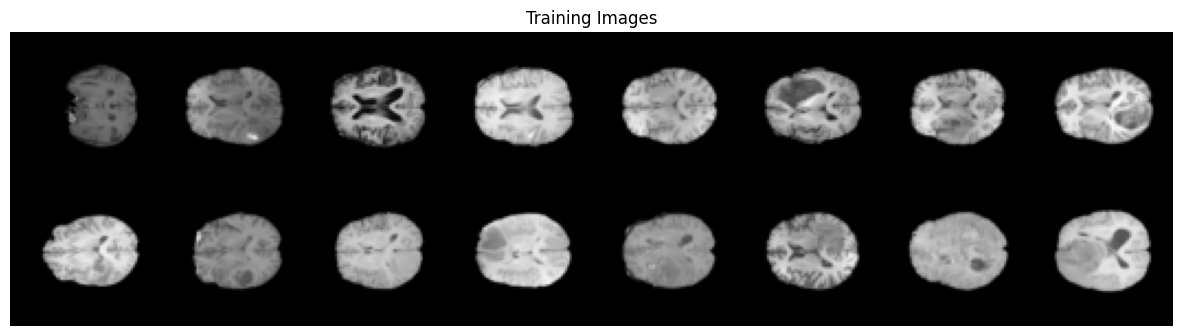

In [8]:
# Plot some training images
print(real_batch.shape)
# Actually plot it
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch.to(device)[:16], padding=2, normalize=True).cpu(),
        (1, 2, 0)
    )
)

In [9]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [10]:
class Critic(nn.Module):
    def __init__(self, use_gp=False) -> None:
        super(Critic, self).__init__()
        if use_gp:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
        else:
            self.main = nn.Sequential(
                # input: 1 x image_size x image_size
                nn.Conv2d(1, feature_map_size, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size),
                nn.LeakyReLU(0.2),
                # input: feature_map_size x image_size/2 x image_size/2
                nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 2),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*2 x image_size/4 x image_size/4
                nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 4),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*4 x image_size/8 x image_size/8
                nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1),
                nn.BatchNorm2d(feature_map_size * 8),
                nn.LeakyReLU(0.2),
                # input: feature_map_size*8 x image_size/16 x image_size/16
                nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0),
                # output: 1 x 1 x 1
            )
    
    def forward(self, input):
        return self.main(input)

In [11]:
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [12]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input: latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, feature_map_size * 8, 4, 1, 0),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*16 x image_size/16 x image_size/16
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*8 x image_size/8 x image_size/8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*4 x image_size/4 x image_size/4
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, 4, 2, 1),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
            # input: feature_map_size*2 x image_size/2 x image_size/2
            nn.ConvTranspose2d(feature_map_size, 1, 4, 2, 1),
            nn.Tanh(),
            # output: 1 x image_size x image_size
        )
    
    def forward(self, input):
        return self.main(input)

In [13]:
generator_model = Generator().to(device)
generator_model.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [14]:
optimizer_generator = optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_critic = optim.Adam(critic_model.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training loop
print("Starting training....")
fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)
img_list = list()
d_loss_hist = list()
g_loss_hist = list()
psnr_hist = list()
ssim_hist = list()
best_psnr = -float("inf")
best_ssim = -float("inf")
best_g_weights = None
best_d_weights = None

print(f"Number of mini batch iterations per epoch: {len(dataloader)}")
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        # Get batch of data
        real_batch = data.to(device)
        b_size = real_batch.shape[0]
        if b_size != batch_size:
            # drop last batch
            continue

        d_loss_vals = list()
        for _ in range(n_critic):
            # Train critic weight for real images
            critic_model.zero_grad()
            d_loss_real = critic_model(real_batch)

            # Update critic weight for fake images
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            fake_batch = generator_model(noise)
            d_loss_fake = critic_model(fake_batch)

            d_loss = -torch.mean(d_loss_real - d_loss_fake)
            if use_gp:
                # Random weight term for interpolation
                alpha = torch.rand(b_size, 1, 1, 1).to(device)
                # Get random interpolations between real and fake
                interpolates = torch.autograd.Variable(alpha * real_batch + (1 - alpha) * fake_batch, requires_grad=True).to(device)
                d_interpolates = critic_model(interpolates)
                fake = torch.autograd.Variable(torch.Tensor(d_interpolates.size()).fill_(1.0), requires_grad=False).to(device)
                # Get gradient w.r.t interpolates
                gradients = torch.autograd.grad(
                    outputs=d_interpolates,
                    inputs=interpolates,
                    grad_outputs=fake,
                    create_graph=True,
                )[0]
                gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
                d_loss += lambda_gp * gradient_penalty
            d_loss_vals.append(d_loss.detach().cpu().numpy())
            d_loss.backward()
            optimizer_critic.step()

            if use_gp:
                # no op
                ...
            else:
                # Clamp critic weights
                for p in critic_model.parameters():
                    p.data.clamp_(-clipping_param, clipping_param)
        
        d_loss_hist.append(np.mean(d_loss_vals))

        # Update generator weight
        generator_model.zero_grad()
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake_batch = generator_model(noise)
        output = critic_model(fake_batch)
        g_loss = -torch.mean(output)
        g_loss_hist.append(g_loss.detach().cpu().numpy())
        g_loss.backward()
        optimizer_generator.step()

        # Save best model based on PSNR every iteration
        psnr_hist.append(
            compute_psnr(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        ssim_hist.append(
            compute_ssim(
                real_batch.detach().cpu().numpy(),
                fake_batch.detach().cpu().numpy()
            )
        )
        if psnr_hist[-1] > best_psnr:
            best_psnr = psnr_hist[-1]
            best_ssim = ssim_hist[-1]
            best_g_weights = generator_model.state_dict()
            best_d_weights = critic_model.state_dict()

    tqdm.write("\n".join((
        f"epoch: {epoch}, d_loss: {d_loss_hist[-1]:.4f}, g_loss: {g_loss_hist[-1]:.4f} ",
        f"psnr: {psnr_hist[-1]:.4f}, best_psnr: {best_psnr:.4f} ",
        f"ssim: {ssim_hist[-1]:.4f}, best_ssim: {best_ssim:.4f} ",
    )))

    # Check how the generator is doing by saving G's output on fixed_noise
    # with torch.no_grad():
    #     fake = generator_model(fixed_noise).detach().cpu()
    # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting training....
Number of mini batch iterations per epoch: 12


0it [00:00, ?it/s]MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_14.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package
12it [00:46,  3.84s/it]

epoch: 0, d_loss: -0.4589, g_loss: 0.2706 
psnr: 8.2506, best_psnr: 8.7698 
ssim: 0.0314, best_ssim: 0.0214 



12it [00:06,  1.84it/s]

epoch: 1, d_loss: -0.8420, g_loss: 0.3676 
psnr: 7.4832, best_psnr: 8.7698 
ssim: 0.0393, best_ssim: 0.0214 



12it [00:06,  1.76it/s]

epoch: 2, d_loss: -0.4572, g_loss: 0.1414 
psnr: 11.4801, best_psnr: 11.4801 
ssim: 0.1399, best_ssim: 0.1399 



12it [00:06,  1.77it/s]

epoch: 3, d_loss: -0.5665, g_loss: 0.1631 
psnr: 12.4517, best_psnr: 12.4517 
ssim: 0.1943, best_ssim: 0.1943 



12it [00:06,  1.79it/s]

epoch: 4, d_loss: -0.4233, g_loss: -0.1675 
psnr: 13.2719, best_psnr: 13.3664 
ssim: 0.2616, best_ssim: 0.2351 



12it [00:06,  1.82it/s]

epoch: 5, d_loss: -0.4220, g_loss: 0.4265 
psnr: 13.8723, best_psnr: 14.0149 
ssim: 0.2675, best_ssim: 0.2542 



12it [00:06,  1.76it/s]

epoch: 6, d_loss: -0.3824, g_loss: 0.0845 
psnr: 13.8849, best_psnr: 14.0149 
ssim: 0.2735, best_ssim: 0.2542 



12it [00:06,  1.73it/s]

epoch: 7, d_loss: -0.3380, g_loss: 0.4425 
psnr: 12.7487, best_psnr: 14.0149 
ssim: 0.1570, best_ssim: 0.2542 



12it [00:06,  1.78it/s]

epoch: 8, d_loss: -0.4378, g_loss: 0.5412 
psnr: 12.7755, best_psnr: 14.0149 
ssim: 0.2383, best_ssim: 0.2542 



12it [00:06,  1.78it/s]

epoch: 9, d_loss: -0.4062, g_loss: 0.0158 
psnr: 13.3035, best_psnr: 14.0149 
ssim: 0.2371, best_ssim: 0.2542 



12it [00:06,  1.86it/s]

epoch: 10, d_loss: -0.5477, g_loss: 0.1530 
psnr: 13.1319, best_psnr: 14.0153 
ssim: 0.2548, best_ssim: 0.2377 



12it [00:06,  1.83it/s]

epoch: 11, d_loss: -0.5830, g_loss: 0.5463 
psnr: 13.3230, best_psnr: 14.2814 
ssim: 0.2204, best_ssim: 0.3272 



12it [00:06,  1.86it/s]

epoch: 12, d_loss: -0.6922, g_loss: 0.3662 
psnr: 13.9742, best_psnr: 14.2814 
ssim: 0.2298, best_ssim: 0.3272 



12it [00:06,  1.72it/s]

epoch: 13, d_loss: -0.4282, g_loss: 0.2767 
psnr: 13.2718, best_psnr: 14.5407 
ssim: 0.1959, best_ssim: 0.2407 



12it [00:06,  1.77it/s]

epoch: 14, d_loss: -0.6018, g_loss: 0.3282 
psnr: 13.2526, best_psnr: 14.5407 
ssim: 0.2270, best_ssim: 0.2407 



12it [00:06,  1.83it/s]

epoch: 15, d_loss: -0.5597, g_loss: 0.5122 
psnr: 13.6163, best_psnr: 14.5407 
ssim: 0.3081, best_ssim: 0.2407 



12it [00:06,  1.74it/s]

epoch: 16, d_loss: -0.5636, g_loss: 0.2257 
psnr: 13.2333, best_psnr: 14.6687 
ssim: 0.2530, best_ssim: 0.3065 



12it [00:06,  1.80it/s]

epoch: 17, d_loss: -0.7019, g_loss: 0.5216 
psnr: 13.5400, best_psnr: 14.7102 
ssim: 0.2538, best_ssim: 0.3152 



12it [00:06,  1.84it/s]

epoch: 18, d_loss: -0.5076, g_loss: 0.5457 
psnr: 12.9837, best_psnr: 14.7102 
ssim: 0.2062, best_ssim: 0.3152 



12it [00:06,  1.75it/s]

epoch: 19, d_loss: -0.6925, g_loss: 0.5702 
psnr: 14.2161, best_psnr: 14.7102 
ssim: 0.2848, best_ssim: 0.3152 



12it [00:06,  1.86it/s]

epoch: 20, d_loss: -0.4622, g_loss: 0.5346 
psnr: 14.1727, best_psnr: 14.7102 
ssim: 0.3045, best_ssim: 0.3152 



12it [00:06,  1.82it/s]

epoch: 21, d_loss: -0.6346, g_loss: 0.4692 
psnr: 14.1301, best_psnr: 14.7102 
ssim: 0.2824, best_ssim: 0.3152 



12it [00:06,  1.80it/s]

epoch: 22, d_loss: -0.7449, g_loss: 0.4683 
psnr: 14.1909, best_psnr: 14.7102 
ssim: 0.3007, best_ssim: 0.3152 



12it [00:06,  1.85it/s]

epoch: 23, d_loss: -0.8599, g_loss: 0.5533 
psnr: 14.2028, best_psnr: 14.7102 
ssim: 0.2766, best_ssim: 0.3152 



12it [00:06,  1.82it/s]

epoch: 24, d_loss: -0.5862, g_loss: 0.1814 
psnr: 13.4202, best_psnr: 14.7102 
ssim: 0.2258, best_ssim: 0.3152 



12it [00:06,  1.80it/s]

epoch: 25, d_loss: -0.7985, g_loss: 0.5530 
psnr: 14.1374, best_psnr: 14.7102 
ssim: 0.2451, best_ssim: 0.3152 



12it [00:06,  1.85it/s]

epoch: 26, d_loss: -1.0166, g_loss: 0.5260 
psnr: 13.6544, best_psnr: 14.7102 
ssim: 0.2631, best_ssim: 0.3152 



12it [00:06,  1.83it/s]

epoch: 27, d_loss: -0.5972, g_loss: 0.1086 
psnr: 13.9473, best_psnr: 14.7513 
ssim: 0.2584, best_ssim: 0.2846 



12it [00:06,  1.88it/s]

epoch: 28, d_loss: -0.7356, g_loss: 0.4440 
psnr: 14.5783, best_psnr: 14.9562 
ssim: 0.2940, best_ssim: 0.3014 



12it [00:06,  1.85it/s]

epoch: 29, d_loss: -0.7236, g_loss: 0.5543 
psnr: 13.5937, best_psnr: 14.9562 
ssim: 0.1779, best_ssim: 0.3014 



12it [00:06,  1.87it/s]

epoch: 30, d_loss: -0.7513, g_loss: 0.5648 
psnr: 13.6490, best_psnr: 14.9562 
ssim: 0.2333, best_ssim: 0.3014 



12it [00:06,  1.86it/s]

epoch: 31, d_loss: -0.4282, g_loss: 0.5318 
psnr: 13.8516, best_psnr: 14.9562 
ssim: 0.2621, best_ssim: 0.3014 



12it [00:06,  1.82it/s]

epoch: 32, d_loss: -0.8648, g_loss: 0.5416 
psnr: 13.7648, best_psnr: 14.9562 
ssim: 0.2111, best_ssim: 0.3014 



12it [00:06,  1.79it/s]

epoch: 33, d_loss: -0.5825, g_loss: 0.5566 
psnr: 13.8014, best_psnr: 14.9562 
ssim: 0.2224, best_ssim: 0.3014 



12it [00:06,  1.80it/s]

epoch: 34, d_loss: -0.8534, g_loss: 0.3425 
psnr: 14.0614, best_psnr: 14.9562 
ssim: 0.2542, best_ssim: 0.3014 



12it [00:06,  1.78it/s]

epoch: 35, d_loss: -0.7718, g_loss: 0.5722 
psnr: 14.5645, best_psnr: 15.2335 
ssim: 0.2542, best_ssim: 0.2665 



12it [00:06,  1.80it/s]

epoch: 36, d_loss: -0.7735, g_loss: 0.5765 
psnr: 13.9525, best_psnr: 15.2335 
ssim: 0.2524, best_ssim: 0.2665 



12it [00:06,  1.74it/s]

epoch: 37, d_loss: -0.7308, g_loss: 0.6077 
psnr: 14.1330, best_psnr: 15.3251 
ssim: 0.2752, best_ssim: 0.2938 



12it [00:06,  1.77it/s]

epoch: 38, d_loss: -0.7452, g_loss: 0.5596 
psnr: 14.9701, best_psnr: 15.3251 
ssim: 0.2946, best_ssim: 0.2938 



12it [00:06,  1.73it/s]

epoch: 39, d_loss: -0.7938, g_loss: 0.5292 
psnr: 14.2446, best_psnr: 15.3251 
ssim: 0.2516, best_ssim: 0.2938 



12it [00:06,  1.75it/s]

epoch: 40, d_loss: -0.8950, g_loss: 0.2575 
psnr: 14.5619, best_psnr: 15.3251 
ssim: 0.2674, best_ssim: 0.2938 



12it [00:06,  1.80it/s]

epoch: 41, d_loss: -0.8217, g_loss: 0.5997 
psnr: 14.5251, best_psnr: 15.3251 
ssim: 0.2600, best_ssim: 0.2938 



12it [00:06,  1.80it/s]

epoch: 42, d_loss: -0.7918, g_loss: 0.6172 
psnr: 13.8118, best_psnr: 15.3251 
ssim: 0.2373, best_ssim: 0.2938 



12it [00:06,  1.83it/s]

epoch: 43, d_loss: -0.9211, g_loss: 0.5549 
psnr: 14.2134, best_psnr: 15.3251 
ssim: 0.2320, best_ssim: 0.2938 



12it [00:06,  1.76it/s]

epoch: 44, d_loss: -0.6143, g_loss: 0.5544 
psnr: 14.3764, best_psnr: 15.3251 
ssim: 0.2343, best_ssim: 0.2938 



12it [00:06,  1.89it/s]

epoch: 45, d_loss: -0.7282, g_loss: 0.5934 
psnr: 14.2677, best_psnr: 15.3251 
ssim: 0.2514, best_ssim: 0.2938 



12it [00:06,  1.75it/s]

epoch: 46, d_loss: -0.8615, g_loss: 0.5764 
psnr: 13.6777, best_psnr: 15.3251 
ssim: 0.2321, best_ssim: 0.2938 



12it [00:06,  1.84it/s]

epoch: 47, d_loss: -0.7433, g_loss: 0.5724 
psnr: 13.9100, best_psnr: 15.3251 
ssim: 0.2357, best_ssim: 0.2938 



12it [00:06,  1.81it/s]

epoch: 48, d_loss: -0.8886, g_loss: 0.4269 
psnr: 13.7915, best_psnr: 15.3251 
ssim: 0.2249, best_ssim: 0.2938 



12it [00:06,  1.79it/s]

epoch: 49, d_loss: -0.8831, g_loss: 0.5136 
psnr: 13.9923, best_psnr: 15.3251 
ssim: 0.2358, best_ssim: 0.2938 



12it [00:06,  1.74it/s]

epoch: 50, d_loss: -0.8302, g_loss: 0.2011 
psnr: 13.1966, best_psnr: 15.3251 
ssim: 0.2054, best_ssim: 0.2938 



12it [00:06,  1.79it/s]

epoch: 51, d_loss: -0.8397, g_loss: 0.5692 
psnr: 13.6104, best_psnr: 15.3251 
ssim: 0.2291, best_ssim: 0.2938 



12it [00:06,  1.79it/s]

epoch: 52, d_loss: -0.7496, g_loss: 0.2991 
psnr: 13.0560, best_psnr: 15.3251 
ssim: 0.1909, best_ssim: 0.2938 



12it [00:06,  1.76it/s]

epoch: 53, d_loss: -0.6816, g_loss: 0.4427 
psnr: 13.6600, best_psnr: 15.3251 
ssim: 0.2444, best_ssim: 0.2938 



12it [00:06,  1.72it/s]

epoch: 54, d_loss: -0.6153, g_loss: 0.5125 
psnr: 13.8710, best_psnr: 15.3251 
ssim: 0.2380, best_ssim: 0.2938 



12it [00:06,  1.74it/s]

epoch: 55, d_loss: -0.8433, g_loss: 0.4957 
psnr: 13.7310, best_psnr: 15.3251 
ssim: 0.2350, best_ssim: 0.2938 



12it [00:06,  1.81it/s]

epoch: 56, d_loss: -0.8189, g_loss: 0.4864 
psnr: 14.2302, best_psnr: 15.3251 
ssim: 0.2499, best_ssim: 0.2938 



12it [00:06,  1.77it/s]

epoch: 57, d_loss: -0.7239, g_loss: 0.5016 
psnr: 14.5947, best_psnr: 15.3251 
ssim: 0.2750, best_ssim: 0.2938 



12it [00:06,  1.77it/s]

epoch: 58, d_loss: -0.5695, g_loss: 0.5367 
psnr: 14.2872, best_psnr: 15.3251 
ssim: 0.2700, best_ssim: 0.2938 



12it [00:06,  1.77it/s]

epoch: 59, d_loss: -0.8112, g_loss: 0.5602 
psnr: 13.4921, best_psnr: 15.3251 
ssim: 0.2375, best_ssim: 0.2938 



12it [00:06,  1.80it/s]

epoch: 60, d_loss: -0.6513, g_loss: 0.5347 
psnr: 13.9043, best_psnr: 15.3251 
ssim: 0.2251, best_ssim: 0.2938 



12it [00:06,  1.77it/s]

epoch: 61, d_loss: -0.9037, g_loss: 0.0702 
psnr: 14.4029, best_psnr: 15.3251 
ssim: 0.2570, best_ssim: 0.2938 



12it [00:06,  1.76it/s]

epoch: 62, d_loss: -0.7204, g_loss: 0.5235 
psnr: 14.2806, best_psnr: 15.3251 
ssim: 0.2890, best_ssim: 0.2938 



12it [00:06,  1.76it/s]

epoch: 63, d_loss: -0.7064, g_loss: 0.4662 
psnr: 13.6574, best_psnr: 15.3251 
ssim: 0.2386, best_ssim: 0.2938 



12it [00:06,  1.76it/s]

epoch: 64, d_loss: -0.5020, g_loss: -0.2058 
psnr: 14.4202, best_psnr: 15.3251 
ssim: 0.2360, best_ssim: 0.2938 



12it [00:07,  1.71it/s]

epoch: 65, d_loss: -0.5116, g_loss: 0.2850 
psnr: 14.8921, best_psnr: 15.3599 
ssim: 0.2652, best_ssim: 0.2861 



12it [00:06,  1.78it/s]

epoch: 66, d_loss: -0.5151, g_loss: 0.4958 
psnr: 13.8783, best_psnr: 15.3599 
ssim: 0.2373, best_ssim: 0.2861 



12it [00:06,  1.81it/s]

epoch: 67, d_loss: -0.5413, g_loss: -0.0049 
psnr: 14.7361, best_psnr: 15.3599 
ssim: 0.2675, best_ssim: 0.2861 



12it [00:06,  1.79it/s]

epoch: 68, d_loss: -0.6619, g_loss: 0.5505 
psnr: 14.3016, best_psnr: 15.4756 
ssim: 0.2350, best_ssim: 0.2852 



12it [00:06,  1.83it/s]

epoch: 69, d_loss: -0.4453, g_loss: -0.2491 
psnr: 14.1175, best_psnr: 15.4756 
ssim: 0.2592, best_ssim: 0.2852 



12it [00:06,  1.84it/s]

epoch: 70, d_loss: -0.6471, g_loss: 0.3509 
psnr: 14.4359, best_psnr: 15.4756 
ssim: 0.2556, best_ssim: 0.2852 



12it [00:06,  1.80it/s]

epoch: 71, d_loss: -0.7316, g_loss: 0.5162 
psnr: 14.1984, best_psnr: 15.4756 
ssim: 0.2412, best_ssim: 0.2852 



12it [00:06,  1.82it/s]

epoch: 72, d_loss: -0.6241, g_loss: 0.2825 
psnr: 14.9943, best_psnr: 15.4756 
ssim: 0.2918, best_ssim: 0.2852 



12it [00:06,  1.82it/s]

epoch: 73, d_loss: -0.5894, g_loss: 0.0850 
psnr: 14.4497, best_psnr: 15.4756 
ssim: 0.2657, best_ssim: 0.2852 



12it [00:06,  1.81it/s]

epoch: 74, d_loss: -0.6013, g_loss: 0.3290 
psnr: 14.9899, best_psnr: 15.4756 
ssim: 0.2847, best_ssim: 0.2852 



12it [00:06,  1.76it/s]

epoch: 75, d_loss: -0.7485, g_loss: 0.4211 
psnr: 13.9836, best_psnr: 15.4756 
ssim: 0.2589, best_ssim: 0.2852 



12it [00:06,  1.76it/s]

epoch: 76, d_loss: -0.6160, g_loss: 0.5093 
psnr: 14.5397, best_psnr: 15.4756 
ssim: 0.2901, best_ssim: 0.2852 



12it [00:06,  1.96it/s]

epoch: 77, d_loss: -0.5848, g_loss: 0.1190 
psnr: 14.7650, best_psnr: 15.4756 
ssim: 0.2985, best_ssim: 0.2852 



12it [00:05,  2.04it/s]

epoch: 78, d_loss: -0.4848, g_loss: 0.2531 
psnr: 13.1667, best_psnr: 15.4756 
ssim: 0.2387, best_ssim: 0.2852 



12it [00:06,  1.98it/s]

epoch: 79, d_loss: -0.5000, g_loss: 0.3845 
psnr: 14.2846, best_psnr: 15.4756 
ssim: 0.2680, best_ssim: 0.2852 



12it [00:06,  1.96it/s]

epoch: 80, d_loss: -0.4438, g_loss: 0.2210 
psnr: 15.9345, best_psnr: 15.9345 
ssim: 0.3170, best_ssim: 0.3170 



12it [00:06,  2.00it/s]

epoch: 81, d_loss: -0.4228, g_loss: 0.4878 
psnr: 15.0900, best_psnr: 15.9345 
ssim: 0.2884, best_ssim: 0.3170 



12it [00:06,  1.92it/s]

epoch: 82, d_loss: -0.4146, g_loss: 0.1558 
psnr: 13.7486, best_psnr: 15.9345 
ssim: 0.2359, best_ssim: 0.3170 



12it [00:06,  1.98it/s]

epoch: 83, d_loss: -0.4036, g_loss: 0.0968 
psnr: 15.4170, best_psnr: 15.9345 
ssim: 0.3130, best_ssim: 0.3170 



12it [00:06,  1.97it/s]

epoch: 84, d_loss: -0.6394, g_loss: 0.5457 
psnr: 14.3855, best_psnr: 15.9345 
ssim: 0.2758, best_ssim: 0.3170 



12it [00:05,  2.05it/s]

epoch: 85, d_loss: -0.5563, g_loss: 0.1859 
psnr: 13.7080, best_psnr: 15.9345 
ssim: 0.2339, best_ssim: 0.3170 



12it [00:06,  1.96it/s]

epoch: 86, d_loss: -0.6652, g_loss: 0.3013 
psnr: 14.9559, best_psnr: 15.9345 
ssim: 0.2858, best_ssim: 0.3170 



12it [00:06,  1.93it/s]

epoch: 87, d_loss: -0.5073, g_loss: 0.3638 
psnr: 14.0754, best_psnr: 15.9345 
ssim: 0.2555, best_ssim: 0.3170 



12it [00:06,  1.98it/s]

epoch: 88, d_loss: -0.4471, g_loss: 0.0480 
psnr: 15.3784, best_psnr: 15.9345 
ssim: 0.2808, best_ssim: 0.3170 



12it [00:06,  1.99it/s]

epoch: 89, d_loss: -0.3586, g_loss: 0.2834 
psnr: 14.7895, best_psnr: 15.9345 
ssim: 0.2818, best_ssim: 0.3170 



12it [00:05,  2.02it/s]

epoch: 90, d_loss: -0.5697, g_loss: 0.5200 
psnr: 14.8079, best_psnr: 15.9345 
ssim: 0.2821, best_ssim: 0.3170 



12it [00:06,  2.00it/s]

epoch: 91, d_loss: -0.5542, g_loss: 0.1309 
psnr: 14.6464, best_psnr: 15.9834 
ssim: 0.3075, best_ssim: 0.3469 



12it [00:06,  1.95it/s]

epoch: 92, d_loss: -0.6473, g_loss: 0.5381 
psnr: 15.3637, best_psnr: 15.9834 
ssim: 0.3110, best_ssim: 0.3469 



12it [00:05,  2.02it/s]

epoch: 93, d_loss: -0.4803, g_loss: 0.2163 
psnr: 15.4692, best_psnr: 15.9834 
ssim: 0.2996, best_ssim: 0.3469 



12it [00:06,  1.99it/s]

epoch: 94, d_loss: -0.5280, g_loss: 0.4886 
psnr: 14.4997, best_psnr: 15.9834 
ssim: 0.2647, best_ssim: 0.3469 



12it [00:06,  1.98it/s]

epoch: 95, d_loss: -0.5801, g_loss: 0.1211 
psnr: 14.6863, best_psnr: 15.9834 
ssim: 0.2809, best_ssim: 0.3469 



12it [00:06,  1.99it/s]

epoch: 96, d_loss: -0.4732, g_loss: 0.4525 
psnr: 14.8996, best_psnr: 15.9834 
ssim: 0.2684, best_ssim: 0.3469 



12it [00:06,  1.95it/s]

epoch: 97, d_loss: -0.5609, g_loss: -0.0823 
psnr: 14.7882, best_psnr: 15.9834 
ssim: 0.2712, best_ssim: 0.3469 



12it [00:06,  1.95it/s]

epoch: 98, d_loss: -0.5527, g_loss: 0.1177 
psnr: 14.3675, best_psnr: 15.9834 
ssim: 0.2569, best_ssim: 0.3469 



12it [00:06,  1.94it/s]

epoch: 99, d_loss: -0.7185, g_loss: 0.5075 
psnr: 14.7747, best_psnr: 15.9834 
ssim: 0.2953, best_ssim: 0.3469 



12it [00:06,  1.92it/s]

epoch: 100, d_loss: -0.5220, g_loss: -0.2474 
psnr: 16.0564, best_psnr: 16.0564 
ssim: 0.3263, best_ssim: 0.3263 



12it [00:06,  1.89it/s]

epoch: 101, d_loss: -0.6337, g_loss: -0.1022 
psnr: 14.8452, best_psnr: 16.0564 
ssim: 0.3108, best_ssim: 0.3263 



12it [00:06,  1.99it/s]

epoch: 102, d_loss: -0.5713, g_loss: 0.1064 
psnr: 15.0771, best_psnr: 16.0564 
ssim: 0.2956, best_ssim: 0.3263 



12it [00:06,  1.96it/s]

epoch: 103, d_loss: -0.4198, g_loss: -0.0826 
psnr: 15.2476, best_psnr: 16.0564 
ssim: 0.3110, best_ssim: 0.3263 



12it [00:06,  1.96it/s]

epoch: 104, d_loss: -0.4811, g_loss: 0.0874 
psnr: 15.4552, best_psnr: 16.0564 
ssim: 0.3420, best_ssim: 0.3263 



12it [00:05,  2.08it/s]

epoch: 105, d_loss: -0.3374, g_loss: 0.1270 
psnr: 14.1016, best_psnr: 16.0564 
ssim: 0.2654, best_ssim: 0.3263 



12it [00:06,  1.96it/s]

epoch: 106, d_loss: -0.6469, g_loss: -0.1842 
psnr: 15.6055, best_psnr: 16.0564 
ssim: 0.3069, best_ssim: 0.3263 



12it [00:06,  1.96it/s]

epoch: 107, d_loss: -0.4544, g_loss: 0.5160 
psnr: 15.3358, best_psnr: 16.0564 
ssim: 0.2902, best_ssim: 0.3263 



12it [00:06,  1.96it/s]

epoch: 108, d_loss: -0.4859, g_loss: 0.4406 
psnr: 14.5466, best_psnr: 16.0564 
ssim: 0.2623, best_ssim: 0.3263 



12it [00:06,  1.98it/s]

epoch: 109, d_loss: -0.6872, g_loss: -0.1847 
psnr: 13.4568, best_psnr: 16.0564 
ssim: 0.2332, best_ssim: 0.3263 



12it [00:06,  1.96it/s]

epoch: 110, d_loss: -0.6218, g_loss: 0.4766 
psnr: 14.9652, best_psnr: 16.0564 
ssim: 0.3000, best_ssim: 0.3263 



12it [00:06,  1.91it/s]

epoch: 111, d_loss: -0.6063, g_loss: -0.1518 
psnr: 14.4527, best_psnr: 16.0564 
ssim: 0.2641, best_ssim: 0.3263 



12it [00:05,  2.06it/s]

epoch: 112, d_loss: -0.6414, g_loss: 0.4521 
psnr: 15.4074, best_psnr: 16.0564 
ssim: 0.3079, best_ssim: 0.3263 



12it [00:06,  1.94it/s]

epoch: 113, d_loss: -0.5707, g_loss: 0.2599 
psnr: 14.9982, best_psnr: 16.0564 
ssim: 0.2684, best_ssim: 0.3263 



12it [00:06,  1.92it/s]

epoch: 114, d_loss: -0.4620, g_loss: -0.1893 
psnr: 14.9758, best_psnr: 16.0564 
ssim: 0.2830, best_ssim: 0.3263 



12it [00:06,  1.91it/s]

epoch: 115, d_loss: -0.2831, g_loss: 0.4440 
psnr: 15.0941, best_psnr: 16.0564 
ssim: 0.2722, best_ssim: 0.3263 



12it [00:06,  1.92it/s]

epoch: 116, d_loss: -0.6418, g_loss: 0.5460 
psnr: 14.8943, best_psnr: 16.0564 
ssim: 0.2835, best_ssim: 0.3263 



12it [00:06,  1.95it/s]

epoch: 117, d_loss: -0.3465, g_loss: -0.0755 
psnr: 15.1164, best_psnr: 16.0564 
ssim: 0.3097, best_ssim: 0.3263 



12it [00:06,  1.93it/s]

epoch: 118, d_loss: -0.4197, g_loss: 0.5195 
psnr: 14.1873, best_psnr: 16.0564 
ssim: 0.2875, best_ssim: 0.3263 



12it [00:06,  1.98it/s]

epoch: 119, d_loss: -0.4917, g_loss: 0.0206 
psnr: 15.3262, best_psnr: 16.0564 
ssim: 0.3130, best_ssim: 0.3263 



12it [00:06,  1.98it/s]

epoch: 120, d_loss: -0.4155, g_loss: 0.3240 
psnr: 15.7857, best_psnr: 16.1897 
ssim: 0.3479, best_ssim: 0.3499 



12it [00:06,  1.96it/s]

epoch: 121, d_loss: -0.4635, g_loss: 0.4432 
psnr: 15.5043, best_psnr: 16.1897 
ssim: 0.3305, best_ssim: 0.3499 



12it [00:06,  1.94it/s]

epoch: 122, d_loss: -0.5518, g_loss: 0.5893 
psnr: 14.1357, best_psnr: 16.1897 
ssim: 0.2753, best_ssim: 0.3499 



12it [00:06,  1.98it/s]

epoch: 123, d_loss: -0.5460, g_loss: 0.5400 
psnr: 15.2415, best_psnr: 16.1897 
ssim: 0.3159, best_ssim: 0.3499 



12it [00:05,  2.02it/s]

epoch: 124, d_loss: -0.4289, g_loss: 0.1182 
psnr: 15.3130, best_psnr: 16.1897 
ssim: 0.2911, best_ssim: 0.3499 



12it [00:06,  1.91it/s]

epoch: 125, d_loss: -0.4220, g_loss: 0.4425 
psnr: 15.3291, best_psnr: 16.1897 
ssim: 0.3125, best_ssim: 0.3499 



12it [00:06,  1.98it/s]

epoch: 126, d_loss: -0.3694, g_loss: 0.3726 
psnr: 15.2026, best_psnr: 16.1897 
ssim: 0.3167, best_ssim: 0.3499 



12it [00:06,  1.93it/s]

epoch: 127, d_loss: -0.4087, g_loss: 0.4636 
psnr: 14.7809, best_psnr: 16.1897 
ssim: 0.2709, best_ssim: 0.3499 



12it [00:06,  1.95it/s]

epoch: 128, d_loss: -0.5465, g_loss: 0.2577 
psnr: 14.6410, best_psnr: 16.1897 
ssim: 0.3105, best_ssim: 0.3499 



12it [00:05,  2.03it/s]

epoch: 129, d_loss: -0.3963, g_loss: 0.2866 
psnr: 15.4646, best_psnr: 16.1897 
ssim: 0.3336, best_ssim: 0.3499 



12it [00:06,  1.99it/s]

epoch: 130, d_loss: -0.4372, g_loss: 0.4077 
psnr: 14.9829, best_psnr: 16.1897 
ssim: 0.3089, best_ssim: 0.3499 



12it [00:05,  2.01it/s]

epoch: 131, d_loss: -0.4119, g_loss: 0.1555 
psnr: 15.4625, best_psnr: 16.1897 
ssim: 0.3013, best_ssim: 0.3499 



12it [00:05,  2.02it/s]

epoch: 132, d_loss: -0.2409, g_loss: -0.0286 
psnr: 15.5202, best_psnr: 16.1897 
ssim: 0.3018, best_ssim: 0.3499 



12it [00:05,  2.02it/s]

epoch: 133, d_loss: -0.3930, g_loss: 0.4270 
psnr: 14.4797, best_psnr: 16.1897 
ssim: 0.2559, best_ssim: 0.3499 



12it [00:06,  1.96it/s]

epoch: 134, d_loss: -0.3659, g_loss: -0.0965 
psnr: 15.0765, best_psnr: 16.1897 
ssim: 0.2967, best_ssim: 0.3499 



12it [00:05,  2.05it/s]

epoch: 135, d_loss: -0.3119, g_loss: 0.0924 
psnr: 15.0680, best_psnr: 16.1897 
ssim: 0.2873, best_ssim: 0.3499 



12it [00:06,  1.95it/s]

epoch: 136, d_loss: -0.2886, g_loss: 0.1160 
psnr: 15.4139, best_psnr: 16.1897 
ssim: 0.3045, best_ssim: 0.3499 



12it [00:06,  1.93it/s]

epoch: 137, d_loss: -0.5102, g_loss: 0.1800 
psnr: 14.8769, best_psnr: 16.1897 
ssim: 0.2913, best_ssim: 0.3499 



12it [00:06,  1.99it/s]

epoch: 138, d_loss: -0.2399, g_loss: 0.3362 
psnr: 15.4833, best_psnr: 16.1897 
ssim: 0.3037, best_ssim: 0.3499 



12it [00:06,  1.89it/s]

epoch: 139, d_loss: -0.3504, g_loss: 0.5198 
psnr: 15.0358, best_psnr: 16.1897 
ssim: 0.2923, best_ssim: 0.3499 



12it [00:06,  1.98it/s]

epoch: 140, d_loss: -0.3027, g_loss: -0.0247 
psnr: 14.8607, best_psnr: 16.1897 
ssim: 0.3170, best_ssim: 0.3499 



12it [00:06,  1.96it/s]

epoch: 141, d_loss: -0.3696, g_loss: 0.0663 
psnr: 15.8803, best_psnr: 16.1897 
ssim: 0.3303, best_ssim: 0.3499 



12it [00:06,  1.90it/s]

epoch: 142, d_loss: -0.3625, g_loss: 0.3751 
psnr: 15.4817, best_psnr: 16.1897 
ssim: 0.2971, best_ssim: 0.3499 



12it [00:06,  2.00it/s]

epoch: 143, d_loss: -0.3340, g_loss: 0.1274 
psnr: 15.1302, best_psnr: 16.1897 
ssim: 0.2998, best_ssim: 0.3499 



12it [00:06,  1.99it/s]

epoch: 144, d_loss: -0.4039, g_loss: 0.0484 
psnr: 15.1836, best_psnr: 16.1897 
ssim: 0.2899, best_ssim: 0.3499 



12it [00:06,  1.98it/s]

epoch: 145, d_loss: -0.3532, g_loss: 0.0844 
psnr: 15.2492, best_psnr: 16.1897 
ssim: 0.2955, best_ssim: 0.3499 



12it [00:06,  1.97it/s]

epoch: 146, d_loss: -0.2557, g_loss: -0.3039 
psnr: 14.3063, best_psnr: 16.1897 
ssim: 0.2856, best_ssim: 0.3499 



12it [00:06,  1.96it/s]

epoch: 147, d_loss: -0.2439, g_loss: 0.5981 
psnr: 15.0485, best_psnr: 16.3272 
ssim: 0.3021, best_ssim: 0.3363 



12it [00:05,  2.01it/s]

epoch: 148, d_loss: -0.2181, g_loss: 0.1465 
psnr: 15.7922, best_psnr: 16.3317 
ssim: 0.3215, best_ssim: 0.3148 



12it [00:06,  1.96it/s]

epoch: 149, d_loss: -0.2222, g_loss: 0.0348 
psnr: 15.8310, best_psnr: 16.3317 
ssim: 0.3477, best_ssim: 0.3148 



12it [00:06,  1.90it/s]

epoch: 150, d_loss: -0.3648, g_loss: 0.4004 
psnr: 15.1260, best_psnr: 16.3317 
ssim: 0.2880, best_ssim: 0.3148 



12it [00:06,  1.99it/s]

epoch: 151, d_loss: -0.2370, g_loss: -0.0434 
psnr: 14.9523, best_psnr: 16.3317 
ssim: 0.2946, best_ssim: 0.3148 



12it [00:06,  1.99it/s]

epoch: 152, d_loss: -0.4011, g_loss: -0.1118 
psnr: 15.6333, best_psnr: 16.3317 
ssim: 0.3340, best_ssim: 0.3148 



12it [00:06,  1.97it/s]

epoch: 153, d_loss: -0.1284, g_loss: 0.2759 
psnr: 15.7913, best_psnr: 16.3317 
ssim: 0.3191, best_ssim: 0.3148 



12it [00:06,  1.95it/s]

epoch: 154, d_loss: -0.2791, g_loss: 0.2118 
psnr: 15.8326, best_psnr: 16.3317 
ssim: 0.3272, best_ssim: 0.3148 



12it [00:06,  1.92it/s]

epoch: 155, d_loss: -0.3041, g_loss: 0.5449 
psnr: 14.8034, best_psnr: 16.3317 
ssim: 0.3013, best_ssim: 0.3148 



12it [00:06,  1.95it/s]

epoch: 156, d_loss: -0.2907, g_loss: 0.3757 
psnr: 15.9130, best_psnr: 16.3317 
ssim: 0.3469, best_ssim: 0.3148 



12it [00:06,  1.96it/s]

epoch: 157, d_loss: -0.2235, g_loss: 0.0473 
psnr: 14.6477, best_psnr: 16.5125 
ssim: 0.2936, best_ssim: 0.3658 



12it [00:06,  1.98it/s]

epoch: 158, d_loss: -0.3689, g_loss: -0.1093 
psnr: 15.3778, best_psnr: 16.5125 
ssim: 0.3467, best_ssim: 0.3658 



12it [00:06,  1.90it/s]

epoch: 159, d_loss: -0.2433, g_loss: -0.2895 
psnr: 16.2982, best_psnr: 16.5125 
ssim: 0.3604, best_ssim: 0.3658 



12it [00:06,  1.95it/s]

epoch: 160, d_loss: -0.2095, g_loss: 0.3554 
psnr: 15.0623, best_psnr: 16.5125 
ssim: 0.3246, best_ssim: 0.3658 



12it [00:06,  1.98it/s]

epoch: 161, d_loss: -0.2157, g_loss: 0.1242 
psnr: 15.8642, best_psnr: 16.5125 
ssim: 0.3247, best_ssim: 0.3658 



12it [00:06,  1.96it/s]

epoch: 162, d_loss: -0.2484, g_loss: 0.5428 
psnr: 15.8091, best_psnr: 16.5125 
ssim: 0.3568, best_ssim: 0.3658 



12it [00:06,  1.96it/s]

epoch: 163, d_loss: -0.3297, g_loss: 0.2475 
psnr: 15.6756, best_psnr: 16.5125 
ssim: 0.3394, best_ssim: 0.3658 



12it [00:06,  1.88it/s]

epoch: 164, d_loss: -0.2911, g_loss: 0.4705 
psnr: 15.3107, best_psnr: 16.5125 
ssim: 0.3508, best_ssim: 0.3658 



12it [00:06,  1.93it/s]

epoch: 165, d_loss: -0.2827, g_loss: 0.4100 
psnr: 15.9253, best_psnr: 16.5125 
ssim: 0.3593, best_ssim: 0.3658 



12it [00:05,  2.02it/s]

epoch: 166, d_loss: -0.3142, g_loss: 0.4444 
psnr: 15.8378, best_psnr: 16.7559 
ssim: 0.3468, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 167, d_loss: -0.1828, g_loss: 0.1738 
psnr: 15.7358, best_psnr: 16.7559 
ssim: 0.3448, best_ssim: 0.3811 



12it [00:05,  2.06it/s]

epoch: 168, d_loss: -0.2332, g_loss: 0.5083 
psnr: 15.5610, best_psnr: 16.7559 
ssim: 0.2919, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 169, d_loss: -0.1904, g_loss: -0.1116 
psnr: 15.8922, best_psnr: 16.7559 
ssim: 0.3457, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 170, d_loss: -0.2637, g_loss: 0.4640 
psnr: 15.8320, best_psnr: 16.7559 
ssim: 0.3571, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 171, d_loss: -0.2981, g_loss: 0.3649 
psnr: 15.1987, best_psnr: 16.7559 
ssim: 0.3095, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 172, d_loss: -0.3044, g_loss: 0.2970 
psnr: 15.5303, best_psnr: 16.7559 
ssim: 0.3197, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 173, d_loss: -0.2541, g_loss: 0.1935 
psnr: 15.5009, best_psnr: 16.7559 
ssim: 0.3422, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 174, d_loss: -0.2982, g_loss: 0.3518 
psnr: 15.5048, best_psnr: 16.7559 
ssim: 0.3658, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 175, d_loss: -0.2148, g_loss: -0.2444 
psnr: 14.9700, best_psnr: 16.7559 
ssim: 0.2926, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 176, d_loss: -0.3782, g_loss: 0.4332 
psnr: 16.6736, best_psnr: 16.7559 
ssim: 0.4032, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 177, d_loss: -0.1892, g_loss: 0.1523 
psnr: 15.4467, best_psnr: 16.7559 
ssim: 0.3113, best_ssim: 0.3811 



12it [00:06,  1.88it/s]

epoch: 178, d_loss: -0.2744, g_loss: 0.3828 
psnr: 15.5605, best_psnr: 16.7559 
ssim: 0.3393, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 179, d_loss: -0.1090, g_loss: 0.2932 
psnr: 15.3662, best_psnr: 16.7559 
ssim: 0.3495, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 180, d_loss: -0.3444, g_loss: 0.3523 
psnr: 16.2453, best_psnr: 16.7559 
ssim: 0.3738, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 181, d_loss: -0.2274, g_loss: 0.4453 
psnr: 15.6773, best_psnr: 16.7559 
ssim: 0.3875, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 182, d_loss: -0.3651, g_loss: -0.2668 
psnr: 15.4524, best_psnr: 16.7559 
ssim: 0.3732, best_ssim: 0.3811 



12it [00:06,  2.00it/s]

epoch: 183, d_loss: -0.4207, g_loss: 0.5368 
psnr: 15.9740, best_psnr: 16.7559 
ssim: 0.3538, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 184, d_loss: -0.3122, g_loss: 0.4721 
psnr: 15.8040, best_psnr: 16.7559 
ssim: 0.3803, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 185, d_loss: -0.2692, g_loss: 0.4093 
psnr: 15.9188, best_psnr: 16.7559 
ssim: 0.3304, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 186, d_loss: -0.3788, g_loss: 0.4915 
psnr: 15.3649, best_psnr: 16.7559 
ssim: 0.3417, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 187, d_loss: -0.2222, g_loss: 0.3718 
psnr: 14.3125, best_psnr: 16.7559 
ssim: 0.3054, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 188, d_loss: -0.3332, g_loss: -0.0473 
psnr: 15.5782, best_psnr: 16.7559 
ssim: 0.2871, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 189, d_loss: -0.3853, g_loss: -0.1028 
psnr: 15.2705, best_psnr: 16.7559 
ssim: 0.3238, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 190, d_loss: -0.3605, g_loss: 0.0861 
psnr: 15.9853, best_psnr: 16.7559 
ssim: 0.3910, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 191, d_loss: -0.3410, g_loss: 0.4617 
psnr: 14.7692, best_psnr: 16.7559 
ssim: 0.3026, best_ssim: 0.3811 



12it [00:05,  2.06it/s]

epoch: 192, d_loss: -0.2957, g_loss: 0.4587 
psnr: 14.9938, best_psnr: 16.7559 
ssim: 0.2742, best_ssim: 0.3811 



12it [00:06,  1.92it/s]

epoch: 193, d_loss: -0.3090, g_loss: -0.1667 
psnr: 15.6659, best_psnr: 16.7559 
ssim: 0.3545, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 194, d_loss: -0.2063, g_loss: 0.2359 
psnr: 15.0287, best_psnr: 16.7559 
ssim: 0.2932, best_ssim: 0.3811 



12it [00:06,  1.92it/s]

epoch: 195, d_loss: -0.2097, g_loss: 0.0011 
psnr: 15.7193, best_psnr: 16.7559 
ssim: 0.3554, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 196, d_loss: -0.3569, g_loss: 0.0042 
psnr: 15.1681, best_psnr: 16.7559 
ssim: 0.3147, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 197, d_loss: -0.2090, g_loss: 0.3546 
psnr: 13.8519, best_psnr: 16.7559 
ssim: 0.2635, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 198, d_loss: -0.3266, g_loss: 0.4692 
psnr: 14.7508, best_psnr: 16.7559 
ssim: 0.3251, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 199, d_loss: -0.3483, g_loss: 0.1089 
psnr: 14.8495, best_psnr: 16.7559 
ssim: 0.3088, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 200, d_loss: -0.3808, g_loss: 0.1446 
psnr: 15.8255, best_psnr: 16.7559 
ssim: 0.3452, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 201, d_loss: -0.2566, g_loss: 0.2830 
psnr: 15.5004, best_psnr: 16.7559 
ssim: 0.3411, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 202, d_loss: -0.3722, g_loss: 0.5088 
psnr: 14.7556, best_psnr: 16.7559 
ssim: 0.3158, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 203, d_loss: -0.2795, g_loss: -0.0955 
psnr: 15.3722, best_psnr: 16.7559 
ssim: 0.3498, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 204, d_loss: -0.3167, g_loss: 0.4400 
psnr: 16.4382, best_psnr: 16.7559 
ssim: 0.4066, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 205, d_loss: -0.3192, g_loss: -0.0818 
psnr: 15.6361, best_psnr: 16.7559 
ssim: 0.3254, best_ssim: 0.3811 



12it [00:06,  2.00it/s]

epoch: 206, d_loss: -0.3298, g_loss: 0.4410 
psnr: 15.4433, best_psnr: 16.7559 
ssim: 0.3560, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 207, d_loss: -0.2242, g_loss: 0.2582 
psnr: 15.8151, best_psnr: 16.7559 
ssim: 0.3220, best_ssim: 0.3811 



12it [00:06,  1.88it/s]

epoch: 208, d_loss: -0.2691, g_loss: 0.2218 
psnr: 14.8263, best_psnr: 16.7559 
ssim: 0.3263, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 209, d_loss: -0.2363, g_loss: 0.3888 
psnr: 15.7555, best_psnr: 16.7559 
ssim: 0.3616, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 210, d_loss: -0.3335, g_loss: -0.2743 
psnr: 15.0913, best_psnr: 16.7559 
ssim: 0.3253, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 211, d_loss: -0.3011, g_loss: 0.4324 
psnr: 14.7874, best_psnr: 16.7559 
ssim: 0.3072, best_ssim: 0.3811 



12it [00:06,  1.87it/s]

epoch: 212, d_loss: -0.2993, g_loss: -0.0587 
psnr: 15.6304, best_psnr: 16.7559 
ssim: 0.3161, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 213, d_loss: -0.3968, g_loss: 0.3079 
psnr: 15.8021, best_psnr: 16.7559 
ssim: 0.3148, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 214, d_loss: -0.2727, g_loss: 0.0810 
psnr: 15.2934, best_psnr: 16.7559 
ssim: 0.3386, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 215, d_loss: -0.2871, g_loss: 0.4111 
psnr: 15.7434, best_psnr: 16.7559 
ssim: 0.3237, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 216, d_loss: -0.2754, g_loss: -0.2861 
psnr: 15.0578, best_psnr: 16.7559 
ssim: 0.3072, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 217, d_loss: -0.2994, g_loss: 0.1045 
psnr: 15.5255, best_psnr: 16.7559 
ssim: 0.3416, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 218, d_loss: -0.3873, g_loss: -0.1448 
psnr: 15.2604, best_psnr: 16.7559 
ssim: 0.2828, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 219, d_loss: -0.3619, g_loss: 0.3994 
psnr: 14.6716, best_psnr: 16.7559 
ssim: 0.2784, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 220, d_loss: -0.3034, g_loss: 0.0322 
psnr: 15.5918, best_psnr: 16.7559 
ssim: 0.3256, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 221, d_loss: -0.1546, g_loss: -0.0478 
psnr: 15.8437, best_psnr: 16.7559 
ssim: 0.3078, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 222, d_loss: -0.2334, g_loss: 0.4087 
psnr: 15.8688, best_psnr: 16.7559 
ssim: 0.3315, best_ssim: 0.3811 



12it [00:06,  1.87it/s]

epoch: 223, d_loss: -0.2358, g_loss: 0.3904 
psnr: 15.6726, best_psnr: 16.7559 
ssim: 0.3226, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 224, d_loss: -0.2694, g_loss: 0.1847 
psnr: 15.4560, best_psnr: 16.7559 
ssim: 0.3185, best_ssim: 0.3811 



12it [00:05,  2.05it/s]

epoch: 225, d_loss: -0.2373, g_loss: -0.1375 
psnr: 15.6015, best_psnr: 16.7559 
ssim: 0.3259, best_ssim: 0.3811 



12it [00:05,  2.05it/s]

epoch: 226, d_loss: -0.2587, g_loss: 0.3918 
psnr: 15.0669, best_psnr: 16.7559 
ssim: 0.3294, best_ssim: 0.3811 



12it [00:06,  2.00it/s]

epoch: 227, d_loss: -0.2625, g_loss: 0.3662 
psnr: 15.5868, best_psnr: 16.7559 
ssim: 0.3454, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 228, d_loss: -0.2293, g_loss: 0.1447 
psnr: 14.7302, best_psnr: 16.7559 
ssim: 0.2862, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 229, d_loss: -0.1798, g_loss: 0.5084 
psnr: 15.6600, best_psnr: 16.7559 
ssim: 0.2804, best_ssim: 0.3811 



12it [00:06,  1.90it/s]

epoch: 230, d_loss: -0.3243, g_loss: 0.3240 
psnr: 15.6928, best_psnr: 16.7559 
ssim: 0.3385, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 231, d_loss: -0.2470, g_loss: -0.1252 
psnr: 15.7166, best_psnr: 16.7559 
ssim: 0.3372, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 232, d_loss: -0.2284, g_loss: 0.3692 
psnr: 14.3844, best_psnr: 16.7559 
ssim: 0.3023, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 233, d_loss: -0.1428, g_loss: 0.3469 
psnr: 15.6180, best_psnr: 16.7559 
ssim: 0.2785, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 234, d_loss: -0.2049, g_loss: 0.2616 
psnr: 15.4087, best_psnr: 16.7559 
ssim: 0.3015, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 235, d_loss: -0.1706, g_loss: 0.4027 
psnr: 15.8077, best_psnr: 16.7559 
ssim: 0.2893, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 236, d_loss: -0.2082, g_loss: -0.2994 
psnr: 15.4695, best_psnr: 16.7559 
ssim: 0.3411, best_ssim: 0.3811 



12it [00:05,  2.06it/s]

epoch: 237, d_loss: -0.1314, g_loss: -0.0672 
psnr: 16.2598, best_psnr: 16.7559 
ssim: 0.3465, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 238, d_loss: -0.1316, g_loss: 0.2922 
psnr: 15.6233, best_psnr: 16.7559 
ssim: 0.3256, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 239, d_loss: -0.1487, g_loss: 0.3176 
psnr: 15.0999, best_psnr: 16.7559 
ssim: 0.3209, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 240, d_loss: -0.1752, g_loss: 0.1651 
psnr: 16.4060, best_psnr: 16.7559 
ssim: 0.3213, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 241, d_loss: -0.1626, g_loss: 0.3160 
psnr: 15.8612, best_psnr: 16.7559 
ssim: 0.3169, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 242, d_loss: -0.1975, g_loss: -0.2476 
psnr: 15.0140, best_psnr: 16.7559 
ssim: 0.3031, best_ssim: 0.3811 



12it [00:06,  1.90it/s]

epoch: 243, d_loss: -0.2163, g_loss: -0.2279 
psnr: 15.8679, best_psnr: 16.7559 
ssim: 0.3356, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 244, d_loss: -0.1211, g_loss: 0.2931 
psnr: 15.6228, best_psnr: 16.7559 
ssim: 0.3440, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 245, d_loss: -0.1647, g_loss: 0.2240 
psnr: 15.3533, best_psnr: 16.7559 
ssim: 0.3353, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 246, d_loss: -0.1598, g_loss: -0.0792 
psnr: 15.8523, best_psnr: 16.7559 
ssim: 0.3238, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 247, d_loss: -0.0661, g_loss: -0.0977 
psnr: 15.1595, best_psnr: 16.7559 
ssim: 0.3074, best_ssim: 0.3811 



12it [00:06,  1.92it/s]

epoch: 248, d_loss: -0.1300, g_loss: 0.4314 
psnr: 15.7924, best_psnr: 16.7559 
ssim: 0.3556, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 249, d_loss: -0.2029, g_loss: 0.2107 
psnr: 15.8707, best_psnr: 16.7559 
ssim: 0.3250, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 250, d_loss: -0.0862, g_loss: 0.0157 
psnr: 15.2508, best_psnr: 16.7559 
ssim: 0.3310, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 251, d_loss: -0.1153, g_loss: -0.2892 
psnr: 16.0684, best_psnr: 16.7559 
ssim: 0.3219, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 252, d_loss: -0.1983, g_loss: 0.4942 
psnr: 15.5677, best_psnr: 16.7559 
ssim: 0.3171, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 253, d_loss: -0.1082, g_loss: 0.4253 
psnr: 16.2896, best_psnr: 16.7559 
ssim: 0.3424, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 254, d_loss: -0.3158, g_loss: -0.0125 
psnr: 15.7883, best_psnr: 16.7559 
ssim: 0.2961, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 255, d_loss: -0.1733, g_loss: -0.1449 
psnr: 15.2556, best_psnr: 16.7559 
ssim: 0.2901, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 256, d_loss: -0.1276, g_loss: 0.3381 
psnr: 15.6789, best_psnr: 16.7559 
ssim: 0.3339, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 257, d_loss: -0.1496, g_loss: -0.4572 
psnr: 15.0563, best_psnr: 16.7559 
ssim: 0.3131, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 258, d_loss: -0.1504, g_loss: -0.1978 
psnr: 15.5674, best_psnr: 16.7559 
ssim: 0.3104, best_ssim: 0.3811 



12it [00:06,  1.90it/s]

epoch: 259, d_loss: -0.1455, g_loss: 0.0825 
psnr: 16.3259, best_psnr: 16.7559 
ssim: 0.3347, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 260, d_loss: -0.2094, g_loss: -0.3343 
psnr: 15.5457, best_psnr: 16.7559 
ssim: 0.3161, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 261, d_loss: -0.1649, g_loss: 0.3897 
psnr: 14.1392, best_psnr: 16.7559 
ssim: 0.2913, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 262, d_loss: -0.0993, g_loss: -0.0877 
psnr: 14.8441, best_psnr: 16.7559 
ssim: 0.2975, best_ssim: 0.3811 



12it [00:06,  1.88it/s]

epoch: 263, d_loss: -0.0819, g_loss: -0.1003 
psnr: 15.5950, best_psnr: 16.7559 
ssim: 0.3192, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 264, d_loss: -0.2561, g_loss: 0.3570 
psnr: 14.5350, best_psnr: 16.7559 
ssim: 0.2805, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 265, d_loss: -0.1007, g_loss: -0.3030 
psnr: 14.6496, best_psnr: 16.7559 
ssim: 0.2917, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 266, d_loss: -0.3278, g_loss: -0.0198 
psnr: 15.6604, best_psnr: 16.7559 
ssim: 0.3889, best_ssim: 0.3811 



12it [00:06,  1.99it/s]

epoch: 267, d_loss: 0.0234, g_loss: 0.4024 
psnr: 15.2388, best_psnr: 16.7559 
ssim: 0.2407, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 268, d_loss: -0.0939, g_loss: -0.3028 
psnr: 15.9869, best_psnr: 16.7559 
ssim: 0.3932, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 269, d_loss: -0.0975, g_loss: 0.1210 
psnr: 15.5013, best_psnr: 16.7559 
ssim: 0.4712, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 270, d_loss: -0.0428, g_loss: -0.1262 
psnr: 15.5651, best_psnr: 16.7559 
ssim: 0.2936, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 271, d_loss: -0.1253, g_loss: 0.0244 
psnr: 16.0873, best_psnr: 16.7559 
ssim: 0.3825, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 272, d_loss: -0.0842, g_loss: -0.4706 
psnr: 15.3583, best_psnr: 16.7559 
ssim: 0.3422, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 273, d_loss: -0.0743, g_loss: 0.4982 
psnr: 14.9251, best_psnr: 16.7559 
ssim: 0.2268, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 274, d_loss: -0.0509, g_loss: 0.1180 
psnr: 15.5458, best_psnr: 16.7559 
ssim: 0.3559, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 275, d_loss: 0.0077, g_loss: -0.4701 
psnr: 15.8044, best_psnr: 16.7559 
ssim: 0.4009, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 276, d_loss: -0.0397, g_loss: 0.2505 
psnr: 15.9240, best_psnr: 16.7559 
ssim: 0.2865, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 277, d_loss: -0.0089, g_loss: 0.2701 
psnr: 15.7099, best_psnr: 16.7559 
ssim: 0.4219, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 278, d_loss: -0.0540, g_loss: -0.4598 
psnr: 15.5594, best_psnr: 16.7559 
ssim: 0.3147, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 279, d_loss: -0.0542, g_loss: -0.1689 
psnr: 15.8056, best_psnr: 16.7559 
ssim: 0.3406, best_ssim: 0.3811 



12it [00:06,  1.91it/s]

epoch: 280, d_loss: -0.0760, g_loss: 0.0864 
psnr: 16.3606, best_psnr: 16.7559 
ssim: 0.3851, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 281, d_loss: -0.2130, g_loss: 0.2299 
psnr: 15.6252, best_psnr: 16.7559 
ssim: 0.3417, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 282, d_loss: -0.1630, g_loss: -0.0544 
psnr: 15.2609, best_psnr: 16.7559 
ssim: 0.4140, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 283, d_loss: -0.1093, g_loss: 0.1209 
psnr: 15.2583, best_psnr: 16.7559 
ssim: 0.3982, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 284, d_loss: -0.0543, g_loss: 0.3488 
psnr: 15.0959, best_psnr: 16.7559 
ssim: 0.3747, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 285, d_loss: -0.0655, g_loss: -0.3294 
psnr: 14.9018, best_psnr: 16.7559 
ssim: 0.3947, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 286, d_loss: -0.1838, g_loss: -0.2831 
psnr: 16.0376, best_psnr: 16.7559 
ssim: 0.4199, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 287, d_loss: -0.0908, g_loss: 0.0266 
psnr: 16.4014, best_psnr: 16.7559 
ssim: 0.4267, best_ssim: 0.3811 



12it [00:06,  1.92it/s]

epoch: 288, d_loss: -0.0402, g_loss: -0.1918 
psnr: 15.4944, best_psnr: 16.7559 
ssim: 0.4014, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 289, d_loss: -0.1916, g_loss: -0.1569 
psnr: 15.6864, best_psnr: 16.7559 
ssim: 0.4151, best_ssim: 0.3811 



12it [00:05,  2.03it/s]

epoch: 290, d_loss: -0.0450, g_loss: -0.3169 
psnr: 15.6009, best_psnr: 16.7559 
ssim: 0.3613, best_ssim: 0.3811 



12it [00:06,  1.94it/s]

epoch: 291, d_loss: -0.1197, g_loss: -0.2398 
psnr: 15.7591, best_psnr: 16.7559 
ssim: 0.4056, best_ssim: 0.3811 



12it [00:06,  1.97it/s]

epoch: 292, d_loss: -0.0420, g_loss: -0.0257 
psnr: 16.4890, best_psnr: 16.7559 
ssim: 0.4092, best_ssim: 0.3811 



12it [00:05,  2.01it/s]

epoch: 293, d_loss: -0.1284, g_loss: -0.0563 
psnr: 15.2220, best_psnr: 16.7559 
ssim: 0.2983, best_ssim: 0.3811 



12it [00:06,  1.93it/s]

epoch: 294, d_loss: -0.0839, g_loss: -0.4897 
psnr: 14.5994, best_psnr: 16.7559 
ssim: 0.3350, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 295, d_loss: -0.0909, g_loss: -0.0809 
psnr: 15.2014, best_psnr: 16.7559 
ssim: 0.2955, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 296, d_loss: -0.0772, g_loss: 0.1497 
psnr: 15.2907, best_psnr: 16.7559 
ssim: 0.3067, best_ssim: 0.3811 



12it [00:06,  1.96it/s]

epoch: 297, d_loss: -0.0647, g_loss: 0.2466 
psnr: 15.2682, best_psnr: 16.7559 
ssim: 0.2790, best_ssim: 0.3811 



12it [00:05,  2.02it/s]

epoch: 298, d_loss: -0.0709, g_loss: -0.1931 
psnr: 14.5879, best_psnr: 16.7559 
ssim: 0.2682, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 299, d_loss: -0.1181, g_loss: 0.0967 
psnr: 15.4014, best_psnr: 16.7559 
ssim: 0.3058, best_ssim: 0.3811 



12it [00:05,  2.00it/s]

epoch: 300, d_loss: -0.0614, g_loss: -0.5774 
psnr: 15.8099, best_psnr: 16.7559 
ssim: 0.3654, best_ssim: 0.3811 



12it [00:06,  1.95it/s]

epoch: 301, d_loss: -0.0653, g_loss: 0.1692 
psnr: 15.6525, best_psnr: 16.7559 
ssim: 0.4427, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 302, d_loss: -0.0293, g_loss: -0.4734 
psnr: 14.9974, best_psnr: 16.7559 
ssim: 0.2749, best_ssim: 0.3811 



12it [00:06,  1.98it/s]

epoch: 303, d_loss: -0.0361, g_loss: 0.0546 
psnr: 16.1755, best_psnr: 17.0091 
ssim: 0.4826, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 304, d_loss: -0.1066, g_loss: 0.0298 
psnr: 15.2958, best_psnr: 17.0091 
ssim: 0.4324, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 305, d_loss: -0.1130, g_loss: 0.4798 
psnr: 15.7553, best_psnr: 17.0091 
ssim: 0.3112, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 306, d_loss: -0.0375, g_loss: 0.2984 
psnr: 15.2010, best_psnr: 17.0091 
ssim: 0.2647, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 307, d_loss: -0.1869, g_loss: -0.3412 
psnr: 14.8743, best_psnr: 17.0091 
ssim: 0.2957, best_ssim: 0.4623 



12it [00:05,  2.05it/s]

epoch: 308, d_loss: -0.0638, g_loss: -0.3892 
psnr: 15.4191, best_psnr: 17.0091 
ssim: 0.2776, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 309, d_loss: -0.1087, g_loss: -0.6283 
psnr: 14.4851, best_psnr: 17.0091 
ssim: 0.3403, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 310, d_loss: -0.1240, g_loss: 0.2036 
psnr: 14.8494, best_psnr: 17.0091 
ssim: 0.4207, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 311, d_loss: -0.0190, g_loss: 0.0278 
psnr: 15.0483, best_psnr: 17.0091 
ssim: 0.3686, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 312, d_loss: -0.1424, g_loss: -0.3572 
psnr: 14.9884, best_psnr: 17.0091 
ssim: 0.3209, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 313, d_loss: -0.0602, g_loss: -0.0136 
psnr: 16.0711, best_psnr: 17.0091 
ssim: 0.2887, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 314, d_loss: -0.0975, g_loss: 0.4553 
psnr: 15.2316, best_psnr: 17.0091 
ssim: 0.2899, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 315, d_loss: -0.0095, g_loss: 0.0098 
psnr: 15.2621, best_psnr: 17.0091 
ssim: 0.3482, best_ssim: 0.4623 



12it [00:05,  2.04it/s]

epoch: 316, d_loss: -0.1175, g_loss: 0.4089 
psnr: 15.4667, best_psnr: 17.0091 
ssim: 0.3467, best_ssim: 0.4623 



12it [00:06,  1.87it/s]

epoch: 317, d_loss: -0.0304, g_loss: -0.3506 
psnr: 14.7427, best_psnr: 17.0091 
ssim: 0.2743, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 318, d_loss: -0.1062, g_loss: -0.2510 
psnr: 15.1521, best_psnr: 17.0091 
ssim: 0.3715, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 319, d_loss: -0.0726, g_loss: 0.0013 
psnr: 15.3521, best_psnr: 17.0091 
ssim: 0.3310, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 320, d_loss: -0.1827, g_loss: 0.1767 
psnr: 14.6693, best_psnr: 17.0091 
ssim: 0.2846, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 321, d_loss: -0.0562, g_loss: -0.0842 
psnr: 15.9630, best_psnr: 17.0091 
ssim: 0.3683, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 322, d_loss: -0.1167, g_loss: -0.0122 
psnr: 14.5784, best_psnr: 17.0091 
ssim: 0.3027, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 323, d_loss: -0.1813, g_loss: 0.1464 
psnr: 15.3963, best_psnr: 17.0091 
ssim: 0.3833, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 324, d_loss: -0.1882, g_loss: 0.2500 
psnr: 15.4005, best_psnr: 17.0091 
ssim: 0.3608, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 325, d_loss: 0.0104, g_loss: -0.5677 
psnr: 15.0112, best_psnr: 17.0091 
ssim: 0.4346, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 326, d_loss: -0.0471, g_loss: -0.0921 
psnr: 15.8797, best_psnr: 17.0091 
ssim: 0.3270, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 327, d_loss: -0.0708, g_loss: -0.1307 
psnr: 15.3680, best_psnr: 17.0091 
ssim: 0.3647, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 328, d_loss: -0.0711, g_loss: -0.2992 
psnr: 15.1389, best_psnr: 17.0091 
ssim: 0.4246, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 329, d_loss: -0.0454, g_loss: 0.0487 
psnr: 15.8307, best_psnr: 17.0091 
ssim: 0.3668, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 330, d_loss: -0.0459, g_loss: -0.3405 
psnr: 15.2057, best_psnr: 17.0091 
ssim: 0.3663, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 331, d_loss: -0.1071, g_loss: 0.5015 
psnr: 14.4346, best_psnr: 17.0091 
ssim: 0.3030, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 332, d_loss: -0.0822, g_loss: 0.2527 
psnr: 14.4613, best_psnr: 17.0091 
ssim: 0.3270, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 333, d_loss: -0.1400, g_loss: 0.0948 
psnr: 15.1000, best_psnr: 17.0091 
ssim: 0.3604, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 334, d_loss: -0.0896, g_loss: 0.1378 
psnr: 14.7652, best_psnr: 17.0091 
ssim: 0.3249, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 335, d_loss: -0.0970, g_loss: -0.4972 
psnr: 15.7045, best_psnr: 17.0091 
ssim: 0.3345, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 336, d_loss: -0.0051, g_loss: -0.2224 
psnr: 15.6424, best_psnr: 17.0091 
ssim: 0.3354, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 337, d_loss: -0.1442, g_loss: 0.3433 
psnr: 16.0328, best_psnr: 17.0091 
ssim: 0.3453, best_ssim: 0.4623 



12it [00:05,  2.04it/s]

epoch: 338, d_loss: -0.1178, g_loss: 0.2411 
psnr: 14.9596, best_psnr: 17.0091 
ssim: 0.3140, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 339, d_loss: -0.0525, g_loss: -0.5580 
psnr: 15.6266, best_psnr: 17.0091 
ssim: 0.3090, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 340, d_loss: -0.0355, g_loss: -0.2112 
psnr: 13.7208, best_psnr: 17.0091 
ssim: 0.3040, best_ssim: 0.4623 



12it [00:06,  1.90it/s]

epoch: 341, d_loss: -0.1750, g_loss: 0.3227 
psnr: 14.6505, best_psnr: 17.0091 
ssim: 0.3649, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 342, d_loss: -0.0212, g_loss: 0.2636 
psnr: 14.0577, best_psnr: 17.0091 
ssim: 0.2920, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 343, d_loss: -0.1071, g_loss: 0.4168 
psnr: 15.1624, best_psnr: 17.0091 
ssim: 0.3882, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 344, d_loss: -0.0641, g_loss: -0.6082 
psnr: 15.7174, best_psnr: 17.0091 
ssim: 0.3694, best_ssim: 0.4623 



12it [00:05,  2.00it/s]

epoch: 345, d_loss: -0.0778, g_loss: 0.1280 
psnr: 14.9076, best_psnr: 17.0091 
ssim: 0.3723, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 346, d_loss: -0.1020, g_loss: 0.0014 
psnr: 14.1290, best_psnr: 17.0091 
ssim: 0.2878, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 347, d_loss: -0.0545, g_loss: -0.2699 
psnr: 14.7647, best_psnr: 17.0091 
ssim: 0.3554, best_ssim: 0.4623 



12it [00:05,  2.06it/s]

epoch: 348, d_loss: -0.1093, g_loss: 0.3987 
psnr: 15.4616, best_psnr: 17.0091 
ssim: 0.3742, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 349, d_loss: -0.0813, g_loss: -0.2272 
psnr: 15.1616, best_psnr: 17.0091 
ssim: 0.3671, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 350, d_loss: -0.1571, g_loss: 0.3977 
psnr: 15.3578, best_psnr: 17.0091 
ssim: 0.4021, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 351, d_loss: -0.0071, g_loss: 0.1315 
psnr: 14.6226, best_psnr: 17.0091 
ssim: 0.3400, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 352, d_loss: -0.0722, g_loss: -0.5486 
psnr: 15.5468, best_psnr: 17.0091 
ssim: 0.3542, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 353, d_loss: -0.0541, g_loss: 0.2447 
psnr: 14.5198, best_psnr: 17.0091 
ssim: 0.3022, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 354, d_loss: -0.0885, g_loss: -0.1759 
psnr: 15.2528, best_psnr: 17.0091 
ssim: 0.3525, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 355, d_loss: -0.0178, g_loss: 0.0201 
psnr: 15.2429, best_psnr: 17.0091 
ssim: 0.3728, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 356, d_loss: -0.1110, g_loss: 0.1704 
psnr: 14.0346, best_psnr: 17.0091 
ssim: 0.2662, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 357, d_loss: -0.1331, g_loss: -0.0579 
psnr: 14.8714, best_psnr: 17.0091 
ssim: 0.3182, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 358, d_loss: 0.0047, g_loss: 0.3699 
psnr: 14.9714, best_psnr: 17.0091 
ssim: 0.3168, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 359, d_loss: -0.0412, g_loss: -0.3003 
psnr: 14.8591, best_psnr: 17.0091 
ssim: 0.3287, best_ssim: 0.4623 



12it [00:06,  1.90it/s]

epoch: 360, d_loss: -0.0419, g_loss: -0.0057 
psnr: 15.4821, best_psnr: 17.0091 
ssim: 0.4130, best_ssim: 0.4623 



12it [00:05,  2.04it/s]

epoch: 361, d_loss: -0.0923, g_loss: -0.0860 
psnr: 14.7888, best_psnr: 17.0091 
ssim: 0.3046, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 362, d_loss: -0.1103, g_loss: -0.1564 
psnr: 14.5391, best_psnr: 17.0091 
ssim: 0.3393, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 363, d_loss: -0.0496, g_loss: 0.2206 
psnr: 14.9064, best_psnr: 17.0091 
ssim: 0.3254, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 364, d_loss: -0.0953, g_loss: -0.1428 
psnr: 14.8840, best_psnr: 17.0091 
ssim: 0.3351, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 365, d_loss: -0.0826, g_loss: -0.3210 
psnr: 15.3164, best_psnr: 17.0091 
ssim: 0.3829, best_ssim: 0.4623 



12it [00:05,  2.07it/s]

epoch: 366, d_loss: -0.0595, g_loss: 0.3308 
psnr: 15.3043, best_psnr: 17.0091 
ssim: 0.3062, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 367, d_loss: -0.1126, g_loss: 0.0633 
psnr: 14.2612, best_psnr: 17.0091 
ssim: 0.2553, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 368, d_loss: -0.0412, g_loss: 0.0830 
psnr: 14.8220, best_psnr: 17.0091 
ssim: 0.3348, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 369, d_loss: -0.0649, g_loss: 0.0571 
psnr: 14.9694, best_psnr: 17.0091 
ssim: 0.3638, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 370, d_loss: -0.0464, g_loss: -0.3302 
psnr: 15.0730, best_psnr: 17.0091 
ssim: 0.3286, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 371, d_loss: -0.0465, g_loss: -0.0947 
psnr: 14.9062, best_psnr: 17.0091 
ssim: 0.3692, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 372, d_loss: -0.0908, g_loss: -0.2135 
psnr: 15.3553, best_psnr: 17.0091 
ssim: 0.3752, best_ssim: 0.4623 



12it [00:05,  2.04it/s]

epoch: 373, d_loss: -0.0168, g_loss: -0.4816 
psnr: 15.4525, best_psnr: 17.0091 
ssim: 0.3769, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 374, d_loss: 0.0029, g_loss: 0.3134 
psnr: 14.5413, best_psnr: 17.0091 
ssim: 0.2911, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 375, d_loss: -0.0853, g_loss: -0.3243 
psnr: 14.5761, best_psnr: 17.0091 
ssim: 0.3287, best_ssim: 0.4623 



12it [00:05,  2.00it/s]

epoch: 376, d_loss: -0.1719, g_loss: 0.4548 
psnr: 14.9236, best_psnr: 17.0091 
ssim: 0.3248, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 377, d_loss: -0.2315, g_loss: 0.0838 
psnr: 14.7256, best_psnr: 17.0091 
ssim: 0.3025, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 378, d_loss: -0.1328, g_loss: 0.5511 
psnr: 14.6048, best_psnr: 17.0091 
ssim: 0.3128, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 379, d_loss: -0.1297, g_loss: -0.0967 
psnr: 14.6240, best_psnr: 17.0091 
ssim: 0.3107, best_ssim: 0.4623 



12it [00:05,  2.06it/s]

epoch: 380, d_loss: -0.0764, g_loss: 0.0375 
psnr: 13.9839, best_psnr: 17.0091 
ssim: 0.2500, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 381, d_loss: -0.0118, g_loss: -0.0615 
psnr: 15.6501, best_psnr: 17.0091 
ssim: 0.3161, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 382, d_loss: -0.1057, g_loss: -0.2772 
psnr: 14.2615, best_psnr: 17.0091 
ssim: 0.2601, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 383, d_loss: -0.1738, g_loss: 0.3892 
psnr: 15.1895, best_psnr: 17.0091 
ssim: 0.4066, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 384, d_loss: -0.1161, g_loss: -0.2253 
psnr: 15.2141, best_psnr: 17.0091 
ssim: 0.3517, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 385, d_loss: -0.1165, g_loss: -0.2701 
psnr: 15.0493, best_psnr: 17.0091 
ssim: 0.3196, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 386, d_loss: -0.0401, g_loss: 0.3523 
psnr: 15.4117, best_psnr: 17.0091 
ssim: 0.3668, best_ssim: 0.4623 



12it [00:05,  2.04it/s]

epoch: 387, d_loss: -0.1083, g_loss: 0.5459 
psnr: 15.4732, best_psnr: 17.0091 
ssim: 0.4053, best_ssim: 0.4623 



12it [00:05,  2.04it/s]

epoch: 388, d_loss: -0.1688, g_loss: -0.3290 
psnr: 15.1676, best_psnr: 17.0091 
ssim: 0.2855, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 389, d_loss: -0.1912, g_loss: -0.4863 
psnr: 15.1282, best_psnr: 17.0091 
ssim: 0.3237, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 390, d_loss: -0.0249, g_loss: -0.0524 
psnr: 14.3640, best_psnr: 17.0091 
ssim: 0.2695, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 391, d_loss: -0.0310, g_loss: -0.1001 
psnr: 15.0190, best_psnr: 17.0091 
ssim: 0.2402, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 392, d_loss: -0.0856, g_loss: -0.4714 
psnr: 15.0555, best_psnr: 17.0091 
ssim: 0.2453, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 393, d_loss: 0.0011, g_loss: -0.1661 
psnr: 15.0024, best_psnr: 17.0091 
ssim: 0.2408, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 394, d_loss: -0.0730, g_loss: 0.0703 
psnr: 15.0601, best_psnr: 17.0091 
ssim: 0.2468, best_ssim: 0.4623 



12it [00:06,  1.88it/s]

epoch: 395, d_loss: -0.1359, g_loss: -0.2351 
psnr: 14.7799, best_psnr: 17.0091 
ssim: 0.2747, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 396, d_loss: -0.0937, g_loss: 0.1427 
psnr: 14.5462, best_psnr: 17.0091 
ssim: 0.2710, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 397, d_loss: 0.0044, g_loss: -0.1098 
psnr: 14.7257, best_psnr: 17.0091 
ssim: 0.2686, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 398, d_loss: -0.1219, g_loss: 0.2749 
psnr: 15.4687, best_psnr: 17.0091 
ssim: 0.3111, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 399, d_loss: -0.0790, g_loss: -0.0534 
psnr: 14.9665, best_psnr: 17.0091 
ssim: 0.3013, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 400, d_loss: -0.0434, g_loss: 0.0048 
psnr: 15.9646, best_psnr: 17.0091 
ssim: 0.3669, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 401, d_loss: -0.0517, g_loss: 0.3792 
psnr: 15.0903, best_psnr: 17.0091 
ssim: 0.3326, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 402, d_loss: -0.0583, g_loss: 0.1016 
psnr: 15.0947, best_psnr: 17.0091 
ssim: 0.3265, best_ssim: 0.4623 



12it [00:05,  2.00it/s]

epoch: 403, d_loss: -0.1639, g_loss: 0.5356 
psnr: 15.4574, best_psnr: 17.0091 
ssim: 0.3391, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 404, d_loss: -0.1505, g_loss: 0.1637 
psnr: 15.3890, best_psnr: 17.0091 
ssim: 0.3458, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 405, d_loss: -0.0237, g_loss: 0.2465 
psnr: 14.5906, best_psnr: 17.0091 
ssim: 0.3465, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 406, d_loss: -0.1631, g_loss: 0.3357 
psnr: 15.1966, best_psnr: 17.0091 
ssim: 0.3801, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 407, d_loss: -0.1893, g_loss: -0.1833 
psnr: 15.5699, best_psnr: 17.0091 
ssim: 0.3317, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 408, d_loss: -0.1047, g_loss: -0.0147 
psnr: 14.4160, best_psnr: 17.0091 
ssim: 0.3483, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 409, d_loss: -0.0797, g_loss: 0.0123 
psnr: 14.8445, best_psnr: 17.0091 
ssim: 0.3789, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 410, d_loss: -0.1188, g_loss: 0.1765 
psnr: 14.6026, best_psnr: 17.0091 
ssim: 0.2531, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 411, d_loss: -0.0946, g_loss: 0.3559 
psnr: 15.2096, best_psnr: 17.0091 
ssim: 0.3703, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 412, d_loss: -0.1251, g_loss: 0.0204 
psnr: 15.8762, best_psnr: 17.0091 
ssim: 0.3541, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 413, d_loss: -0.0464, g_loss: -0.1080 
psnr: 15.1920, best_psnr: 17.0091 
ssim: 0.3154, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 414, d_loss: -0.0635, g_loss: 0.1029 
psnr: 14.7474, best_psnr: 17.0091 
ssim: 0.2961, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 415, d_loss: -0.1340, g_loss: -0.3550 
psnr: 15.6105, best_psnr: 17.0091 
ssim: 0.3828, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 416, d_loss: -0.0223, g_loss: -0.1259 
psnr: 15.6300, best_psnr: 17.0091 
ssim: 0.3219, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 417, d_loss: -0.0652, g_loss: -0.0483 
psnr: 14.6534, best_psnr: 17.0091 
ssim: 0.2744, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 418, d_loss: -0.1328, g_loss: -0.0190 
psnr: 15.1477, best_psnr: 17.0091 
ssim: 0.2768, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 419, d_loss: -0.0981, g_loss: 0.0913 
psnr: 14.4217, best_psnr: 17.0091 
ssim: 0.2648, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 420, d_loss: -0.0966, g_loss: 0.0481 
psnr: 13.9717, best_psnr: 17.0091 
ssim: 0.2429, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 421, d_loss: -0.0577, g_loss: -0.3481 
psnr: 15.0414, best_psnr: 17.0091 
ssim: 0.3475, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 422, d_loss: -0.0259, g_loss: -0.0818 
psnr: 14.7126, best_psnr: 17.0091 
ssim: 0.3584, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 423, d_loss: -0.0403, g_loss: -0.2591 
psnr: 15.2944, best_psnr: 17.0091 
ssim: 0.3433, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 424, d_loss: -0.0934, g_loss: -0.3345 
psnr: 15.5759, best_psnr: 17.0091 
ssim: 0.4195, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 425, d_loss: -0.1069, g_loss: -0.4332 
psnr: 15.6223, best_psnr: 17.0091 
ssim: 0.4047, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 426, d_loss: -0.1036, g_loss: -0.0354 
psnr: 15.2220, best_psnr: 17.0091 
ssim: 0.4116, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 427, d_loss: -0.0416, g_loss: 0.0425 
psnr: 15.9666, best_psnr: 17.0091 
ssim: 0.3814, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 428, d_loss: -0.1101, g_loss: -0.1899 
psnr: 14.9132, best_psnr: 17.0091 
ssim: 0.4014, best_ssim: 0.4623 



12it [00:05,  2.07it/s]

epoch: 429, d_loss: -0.1104, g_loss: -0.1219 
psnr: 15.4826, best_psnr: 17.0091 
ssim: 0.4357, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 430, d_loss: -0.0828, g_loss: 0.2809 
psnr: 15.4192, best_psnr: 17.0091 
ssim: 0.3966, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 431, d_loss: -0.1199, g_loss: 0.3443 
psnr: 15.4730, best_psnr: 17.0091 
ssim: 0.3630, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 432, d_loss: 0.0064, g_loss: -0.4236 
psnr: 14.5569, best_psnr: 17.0091 
ssim: 0.3359, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 433, d_loss: 0.0082, g_loss: -0.5338 
psnr: 15.4204, best_psnr: 17.0091 
ssim: 0.3112, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 434, d_loss: -0.0255, g_loss: -0.0680 
psnr: 14.1305, best_psnr: 17.0091 
ssim: 0.3450, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 435, d_loss: -0.1095, g_loss: -0.1915 
psnr: 14.5484, best_psnr: 17.0091 
ssim: 0.3379, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 436, d_loss: -0.0029, g_loss: 0.3321 
psnr: 15.4328, best_psnr: 17.0091 
ssim: 0.3718, best_ssim: 0.4623 



12it [00:06,  1.89it/s]

epoch: 437, d_loss: -0.0047, g_loss: 0.0546 
psnr: 15.5218, best_psnr: 17.0091 
ssim: 0.4021, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 438, d_loss: -0.0610, g_loss: 0.0175 
psnr: 14.9910, best_psnr: 17.0091 
ssim: 0.4127, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 439, d_loss: 0.0052, g_loss: -0.5877 
psnr: 14.8040, best_psnr: 17.0091 
ssim: 0.3597, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 440, d_loss: -0.0192, g_loss: -0.4242 
psnr: 14.8571, best_psnr: 17.0091 
ssim: 0.3675, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 441, d_loss: -0.0376, g_loss: 0.0744 
psnr: 15.2968, best_psnr: 17.0091 
ssim: 0.4150, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 442, d_loss: -0.0155, g_loss: -0.0707 
psnr: 15.4157, best_psnr: 17.0091 
ssim: 0.3984, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 443, d_loss: -0.0609, g_loss: 0.4437 
psnr: 15.3972, best_psnr: 17.0091 
ssim: 0.4149, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 444, d_loss: -0.1130, g_loss: 0.3968 
psnr: 16.0236, best_psnr: 17.0091 
ssim: 0.3989, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 445, d_loss: -0.0652, g_loss: -0.2436 
psnr: 15.4787, best_psnr: 17.0091 
ssim: 0.4310, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 446, d_loss: -0.0975, g_loss: 0.0286 
psnr: 15.7245, best_psnr: 17.0091 
ssim: 0.4516, best_ssim: 0.4623 



12it [00:06,  1.89it/s]

epoch: 447, d_loss: -0.0578, g_loss: 0.0596 
psnr: 15.3595, best_psnr: 17.0091 
ssim: 0.4436, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 448, d_loss: 0.0010, g_loss: -0.1847 
psnr: 15.0810, best_psnr: 17.0091 
ssim: 0.4033, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 449, d_loss: -0.1360, g_loss: -0.2767 
psnr: 15.6539, best_psnr: 17.0091 
ssim: 0.3427, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 450, d_loss: -0.0073, g_loss: -0.2587 
psnr: 14.9046, best_psnr: 17.0091 
ssim: 0.2987, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 451, d_loss: -0.0768, g_loss: 0.3165 
psnr: 15.7436, best_psnr: 17.0091 
ssim: 0.3271, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 452, d_loss: -0.1569, g_loss: 0.2475 
psnr: 15.3774, best_psnr: 17.0091 
ssim: 0.2879, best_ssim: 0.4623 



12it [00:05,  2.09it/s]

epoch: 453, d_loss: -0.0479, g_loss: -0.3854 
psnr: 15.3374, best_psnr: 17.0091 
ssim: 0.3060, best_ssim: 0.4623 



12it [00:05,  2.05it/s]

epoch: 454, d_loss: -0.1295, g_loss: -0.0053 
psnr: 14.8039, best_psnr: 17.0091 
ssim: 0.2620, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 455, d_loss: -0.0388, g_loss: -0.5261 
psnr: 14.9882, best_psnr: 17.0091 
ssim: 0.2755, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 456, d_loss: -0.0322, g_loss: -0.0764 
psnr: 15.1055, best_psnr: 17.0091 
ssim: 0.3193, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 457, d_loss: -0.1406, g_loss: 0.3204 
psnr: 15.4688, best_psnr: 17.0091 
ssim: 0.3639, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 458, d_loss: -0.0830, g_loss: 0.0551 
psnr: 15.0207, best_psnr: 17.0091 
ssim: 0.2882, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 459, d_loss: -0.1026, g_loss: 0.3383 
psnr: 14.5696, best_psnr: 17.0091 
ssim: 0.3188, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 460, d_loss: -0.0778, g_loss: -0.1037 
psnr: 14.5570, best_psnr: 17.0091 
ssim: 0.2880, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 461, d_loss: 0.0034, g_loss: 0.0012 
psnr: 14.9025, best_psnr: 17.0091 
ssim: 0.3094, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 462, d_loss: -0.1008, g_loss: 0.4158 
psnr: 15.0301, best_psnr: 17.0091 
ssim: 0.3071, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 463, d_loss: -0.0712, g_loss: -0.0505 
psnr: 14.8137, best_psnr: 17.0091 
ssim: 0.2422, best_ssim: 0.4623 



12it [00:05,  2.00it/s]

epoch: 464, d_loss: -0.0318, g_loss: -0.2667 
psnr: 15.1557, best_psnr: 17.0091 
ssim: 0.2686, best_ssim: 0.4623 



12it [00:06,  1.98it/s]

epoch: 465, d_loss: -0.1324, g_loss: -0.1461 
psnr: 14.9498, best_psnr: 17.0091 
ssim: 0.2561, best_ssim: 0.4623 



12it [00:06,  1.90it/s]

epoch: 466, d_loss: -0.0447, g_loss: -0.0090 
psnr: 15.2902, best_psnr: 17.0091 
ssim: 0.2960, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 467, d_loss: -0.0406, g_loss: -0.2604 
psnr: 14.0839, best_psnr: 17.0091 
ssim: 0.2381, best_ssim: 0.4623 



12it [00:05,  2.05it/s]

epoch: 468, d_loss: -0.1906, g_loss: -0.0627 
psnr: 14.5220, best_psnr: 17.0091 
ssim: 0.3033, best_ssim: 0.4623 



12it [00:05,  2.01it/s]

epoch: 469, d_loss: -0.0020, g_loss: -0.6164 
psnr: 14.6530, best_psnr: 17.0091 
ssim: 0.3101, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 470, d_loss: -0.0289, g_loss: -0.2223 
psnr: 14.7299, best_psnr: 17.0091 
ssim: 0.3175, best_ssim: 0.4623 



12it [00:06,  1.91it/s]

epoch: 471, d_loss: -0.0051, g_loss: -0.2436 
psnr: 15.6672, best_psnr: 17.0091 
ssim: 0.4059, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 472, d_loss: -0.0854, g_loss: -0.0168 
psnr: 15.0058, best_psnr: 17.0091 
ssim: 0.3250, best_ssim: 0.4623 



12it [00:06,  2.00it/s]

epoch: 473, d_loss: -0.1148, g_loss: -0.1764 
psnr: 14.6334, best_psnr: 17.0091 
ssim: 0.3316, best_ssim: 0.4623 



12it [00:06,  1.89it/s]

epoch: 474, d_loss: -0.0108, g_loss: -0.4279 
psnr: 14.6457, best_psnr: 17.0091 
ssim: 0.3062, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 475, d_loss: -0.0731, g_loss: 0.2271 
psnr: 14.9296, best_psnr: 17.0091 
ssim: 0.3767, best_ssim: 0.4623 



12it [00:05,  2.02it/s]

epoch: 476, d_loss: -0.0656, g_loss: -0.3249 
psnr: 14.6598, best_psnr: 17.0091 
ssim: 0.3479, best_ssim: 0.4623 



12it [00:05,  2.03it/s]

epoch: 477, d_loss: -0.0436, g_loss: -0.3986 
psnr: 14.9584, best_psnr: 17.0091 
ssim: 0.3439, best_ssim: 0.4623 



12it [00:06,  1.95it/s]

epoch: 478, d_loss: -0.0099, g_loss: -0.0360 
psnr: 14.9553, best_psnr: 17.0091 
ssim: 0.3402, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 479, d_loss: -0.1686, g_loss: -0.0076 
psnr: 14.2618, best_psnr: 17.0091 
ssim: 0.3741, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 480, d_loss: -0.0033, g_loss: 0.0186 
psnr: 15.2661, best_psnr: 17.0091 
ssim: 0.3532, best_ssim: 0.4623 



12it [00:06,  1.92it/s]

epoch: 481, d_loss: -0.0092, g_loss: -0.3802 
psnr: 15.2370, best_psnr: 17.0091 
ssim: 0.3551, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 482, d_loss: -0.0636, g_loss: -0.0784 
psnr: 16.1256, best_psnr: 17.0091 
ssim: 0.3883, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 483, d_loss: -0.1075, g_loss: -0.1038 
psnr: 14.8444, best_psnr: 17.0091 
ssim: 0.2997, best_ssim: 0.4623 



12it [00:05,  2.05it/s]

epoch: 484, d_loss: -0.1220, g_loss: 0.4947 
psnr: 15.3392, best_psnr: 17.0091 
ssim: 0.3163, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 485, d_loss: -0.2580, g_loss: 0.2051 
psnr: 15.2054, best_psnr: 17.0091 
ssim: 0.3738, best_ssim: 0.4623 



12it [00:06,  1.93it/s]

epoch: 486, d_loss: -0.0767, g_loss: 0.0763 
psnr: 15.4616, best_psnr: 17.0091 
ssim: 0.3983, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 487, d_loss: -0.1101, g_loss: 0.4030 
psnr: 15.3341, best_psnr: 17.0091 
ssim: 0.3145, best_ssim: 0.4623 



12it [00:06,  1.99it/s]

epoch: 488, d_loss: -0.1075, g_loss: 0.1727 
psnr: 14.2427, best_psnr: 17.0091 
ssim: 0.3102, best_ssim: 0.4623 



12it [00:06,  1.96it/s]

epoch: 489, d_loss: -0.0983, g_loss: -0.1722 
psnr: 15.4197, best_psnr: 17.0091 
ssim: 0.3364, best_ssim: 0.4623 



12it [00:06,  1.94it/s]

epoch: 490, d_loss: -0.0457, g_loss: -0.4095 
psnr: 14.1203, best_psnr: 17.0091 
ssim: 0.3355, best_ssim: 0.4623 



12it [00:06,  1.97it/s]

epoch: 491, d_loss: -0.0155, g_loss: -0.3747 
psnr: 15.1792, best_psnr: 17.0091 
ssim: 0.2985, best_ssim: 0.4623 



12it [00:06,  1.78it/s]

epoch: 492, d_loss: -0.0951, g_loss: -0.0475 
psnr: 15.1512, best_psnr: 17.0091 
ssim: 0.2917, best_ssim: 0.4623 



12it [00:06,  1.81it/s]

epoch: 493, d_loss: -0.1344, g_loss: -0.0833 
psnr: 15.2353, best_psnr: 17.0091 
ssim: 0.3759, best_ssim: 0.4623 



12it [00:06,  1.75it/s]

epoch: 494, d_loss: -0.1660, g_loss: 0.5256 
psnr: 16.0747, best_psnr: 17.0091 
ssim: 0.3197, best_ssim: 0.4623 



12it [00:06,  1.77it/s]

epoch: 495, d_loss: -0.0918, g_loss: -0.4715 
psnr: 14.9850, best_psnr: 17.0091 
ssim: 0.3272, best_ssim: 0.4623 



12it [00:06,  1.78it/s]

epoch: 496, d_loss: -0.0290, g_loss: 0.0459 
psnr: 15.6022, best_psnr: 17.0091 
ssim: 0.3825, best_ssim: 0.4623 



12it [00:06,  1.75it/s]

epoch: 497, d_loss: -0.0510, g_loss: 0.0824 
psnr: 15.0021, best_psnr: 17.0091 
ssim: 0.3583, best_ssim: 0.4623 



12it [00:06,  1.80it/s]

epoch: 498, d_loss: -0.0763, g_loss: 0.2251 
psnr: 15.0612, best_psnr: 17.0091 
ssim: 0.3677, best_ssim: 0.4623 



12it [00:06,  1.72it/s]

epoch: 499, d_loss: -0.1045, g_loss: 0.0502 
psnr: 15.4273, best_psnr: 17.0091 
ssim: 0.3476, best_ssim: 0.4623 


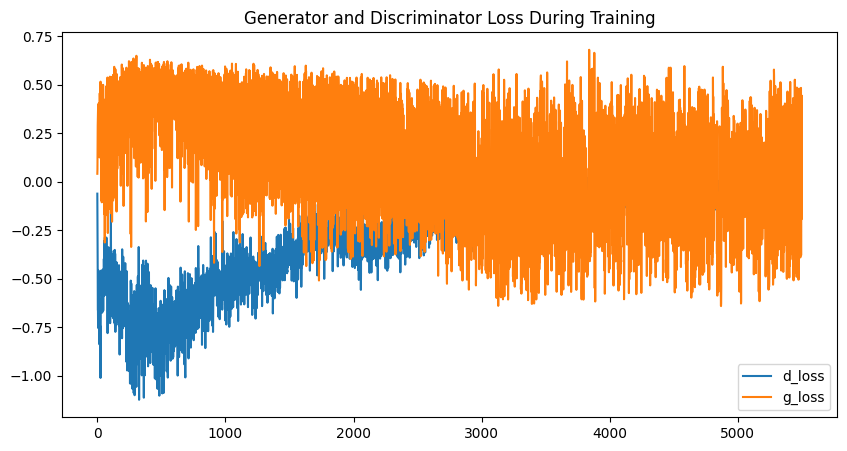

In [16]:
# Plot training history
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_loss_hist, label='d_loss')
plt.plot(g_loss_hist, label='g_loss')
plt.legend()
plt.show()

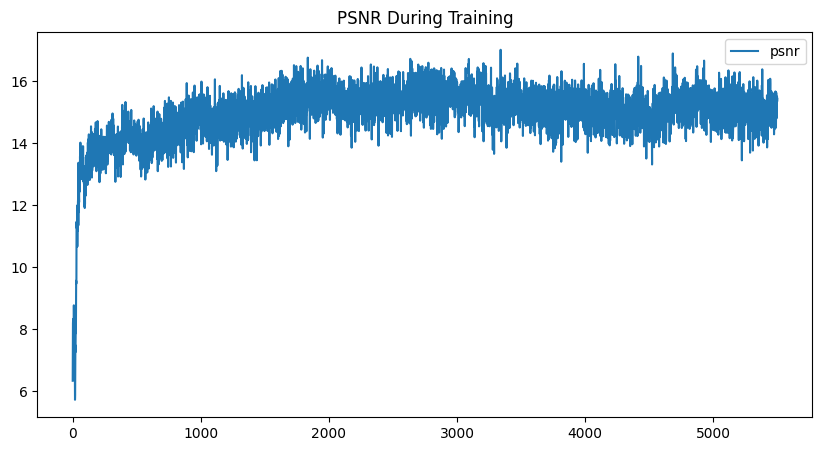

Best PSNR: 17.0091


In [17]:
plt.figure(figsize=(10,5))
plt.title("PSNR During Training")
plt.plot(psnr_hist, label='psnr')
plt.legend()
plt.show()
print(f"Best PSNR: {best_psnr:.4f}")

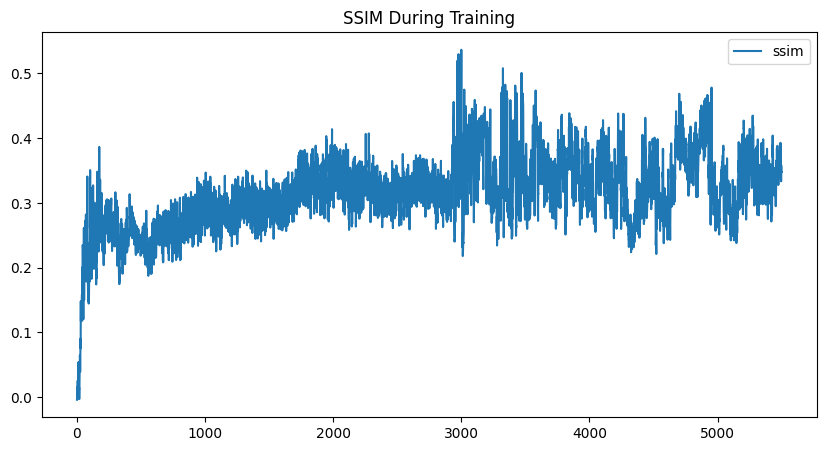

Best SSIM: 0.4623


In [18]:
plt.figure(figsize=(10,5))
plt.title("SSIM During Training")
plt.plot(ssim_hist, label='ssim')
plt.legend()
plt.show()
print(f"Best SSIM: {best_ssim:.4f}")

In [19]:
# fig = plt.figure(figsize=(15,15))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[-50:]]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

In [20]:
# Save models weights
# model dir should be models/wgan_hr_mm_dd_mm
model_dir = "models/wgan_20_22_29_11"
torch.save(best_d_weights, f"{model_dir}/discriminator.pth")
torch.save(best_g_weights, f"{model_dir}/generator.pth")

Critic(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4,

(-0.5, 529.5, 133.5, -0.5)

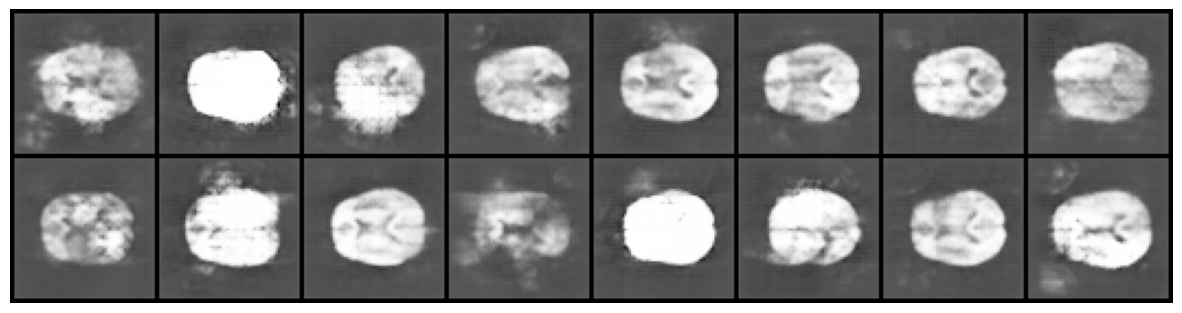

In [21]:
# model dir should be models/dcgan_hr_mm_dd_mm
model_dir = "models/wgan_20_22_29_11"

# Load model and perform inference
critic_model = Critic(use_gp=use_gp).to(device)
critic_model.apply(weight_init)
print(critic_model)

generator_model = Generator().to(device)
generator_model.apply(weight_init)
print(generator_model)

critic_model.load_state_dict(torch.load(f"{model_dir}/discriminator.pth"))
generator_model.load_state_dict(torch.load(f"{model_dir}/generator.pth"))

generator_model.eval()

fixed_noise = torch.randn(16, latent_size, 1, 1, device=device)

fake = generator_model(fixed_noise).detach().cpu()

plt.figure(figsize=(15, 15))
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.axis("off")